# Analysis of site frequency spectrum (SFS) as bulk average over lineages

In [271]:
from __future__ import division
import sys
import os
import time
import copy
import pickle

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# import logit scale
from LogitScale import *
mscale.register_scale(LogitScale)

output_dir = "outs"
output_suffix = ""
output_formats = [".pdf", ".png"]

def save_figure(fig, name, output_dir, output_suffix, output_formats, savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.2}
mpl.rc('savefig', dpi=300)

sns.set_style("ticks")
sns.set_context("talk")

myColors = ["#E69F00", "#56B4E9", "#D55E00", "#009E73"]

# Load data

In [272]:
# Load lineage dynamics data
df_expanded = pd.read_csv("data/df_expanded.csv", index_col=0, header=0)
df_persistent = pd.read_csv("data/df_persistent.csv", index_col=0, header=0)

# Filter for lineages having enough sequences in 2x300 data set to make reasonable SFS
num_seq_V6_Full_cutoff = 100
df_expanded = df_expanded[df_expanded["sequences_V6_Full"] >= num_seq_V6_Full_cutoff]
df_persistent = df_persistent[df_persistent["sequences_V6_Full"] >= num_seq_V6_Full_cutoff]

print "Expanded"
print df_expanded.shape
print
print "Persistent"
print df_persistent.shape

Expanded
(87, 30)

Persistent
(192, 30)


In [340]:
# Report lineages per subject with enough 2x300 reads for analysis
print "Vaccine-responsive"
print pd.Series([str(x)[0] for x in df_expanded.index]).value_counts()
print
print "Persistent"
print pd.Series([str(x)[0] for x in df_persistent.index]).value_counts()

Vaccine-responsive
8    30
6    25
7    24
2     6
3     2
dtype: int64

Persistent
8    60
2    59
7    40
6    32
3     1
dtype: int64


## Load sequence data

In [273]:
def load_data_seqs(infile):
    usecols = [0, 10, 17, 22, 25, 27, 31, 65, 66, 67]
    names = ["uid", "lineage_uid", "patient_uid", "year_visit_str",
             "V_germline", "J_germline", "isotype",
             "mut_germline_positions", "mut_germline_before", "mut_germline_after"]
    dtype = dict([(col, np.object) for col in names])
    dtype["uid"] = np.int64
    dtype["lineage_uid"] = np.int64
    dtype["patient_uid"] = np.int64
    df = pd.read_csv(infile, usecols=usecols, names=names, dtype=dtype, sep="\t", header=None, index_col=None, na_values=["\N"])
    df = df.loc[df["year_visit_str"] == "V6_Full"] # Use only 2x300 sequences
    return df

In [274]:
# Load sequence data (without lineage annotations)
infile = "data/Bcell_flu_high_res.sequences.csv"
df_seqs_all = load_data_seqs(infile)
print df_seqs_all.shape
print "Unique patients:", df_seqs_all.patient_uid.unique()
print "Number of sequences:", df_seqs_all.shape[0]
df_seqs_all.head()

(1041595, 10)
Unique patients: [2 3 6 7 8]
Number of sequences: 1041595


,uid,lineage_uid,patient_uid,year_visit_str,V_germline,J_germline,isotype,mut_germline_positions,mut_germline_before,mut_germline_after
461754,29902010100000002,20201010000037405,2,V6_Full,IGHV4-59*01,IGHJ3*02,IgM,NaN,NaN,NaN
461755,29902010100000004,20201010000000500,2,V6_Full,IGHV3-9*01,IGHJ5*02,IgA,"V14,V21,V31,V32,V82,V83,V90,V97,V163,V169,V170...","T,T,T,T,A,C,T,G,A,A,G,T,C,A,C,C,C,G,G,C","C,C,C,G,G,A,A,C,G,G,C,C,G,G,G,G,T,A,A,T"
461756,29902010100000010,20201010000064503,2,V6_Full,IGHV4-38-2*01,IGHJ4*02,IgA,"V30,V90,V107,V121,V150,V163,V170,V203,V214,V22...","A,C,G,C,G,A,G,T,G,A,A,G,C,T","G,G,A,T,C,G,A,C,T,G,C,C,T,C"
461757,29902010100000014,20201010000000267,2,V6_Full,IGHV4-59*08,IGHJ4*02,IgG,"V69,V76,V77,V92,V93,V95,V96,V99,V123,V155,V156...","T,G,G,G,T,A,C,C,A,A,T,T,A,G,G,T,G,G,A,A,G,A,C,T","C,C,T,T,G,C,T,T,C,T,C,G,G,C,A,G,C,A,C,G,A,G,T,C"
461758,29902010100000019,20201010000000001,2,V6_Full,IGHV3-15*01,IGHJ5*02,IgG,"V21,V39,V40,V82,V88,V89,V104,V105,V147,V149,V1...","T,G,C,A,A,G,G,C,C,G,G,A,C,T,A,A,C,C,C,T,C,C,G,...","A,A,G,G,G,A,A,T,T,A,C,G,T,G,G,T,A,T,G,C,T,G,A,..."


In [275]:
# Only keep lineages that are in our focal set
df_seqs = df_seqs_all[df_seqs_all["lineage_uid"].isin(list(df_expanded.index) + list(df_persistent.index))]
print df_seqs.shape

(269906, 10)


In [276]:
# Write filtered data to file
df_expanded.to_csv("data/df_expanded.filtered.csv")
df_persistent.to_csv("data/df_persistent.filtered.csv")
df_seqs.to_csv("data/df_seqs.filtered_V6_Full.csv")

# Calculate site frequency spectrum (SFS) of each lineage

In [277]:
import bct
reload(bct)

<module 'bct' from 'bct.pyc'>

In [278]:
# Get frequencies of somatic mutations
freqs_with_germline_muts = bct.get_muts_freqs_all(df_seqs) # takes ~10 sec

# Get number of leaves in each tree
lineage_sizes = bct.get_lineage_size_all(df_seqs)

Wall clock time 6.37632083893



In [279]:
# Drop germline mutations
germline_muts = bct.load_germline_muts("data/")
lineage_to_alleles = bct.make_lineage_to_alleles(df_seqs)
freqs = bct.drop_germline_muts(freqs_with_germline_muts, germline_muts, lineage_to_alleles)

Dropped germline mutations 151


In [280]:
# Choose bins for SFS
bins = np.array([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 0.99999])
bin_centers_manual = np.array([5e-5, 5e-4, 5e-3, 5e-2, 0.25, 0.75, 1-5e-2, 1-5e-3, 1-5e-4, 1-5e-5])
bin_centers = np.sqrt(bins[1:] * bins[:-1])

In [281]:
# Write freqs to file
pickle.dump(freqs, open("data/SFS_Bulk_freqs.pickle", 'w'))
pickle.dump(lineage_sizes, open("data/SFS_Bulk_lineage_sizes.pickle", 'w'))

# Simulate populations for comparison

In [282]:
# Function to simulate lineages with sampled population sizes

import random
import sfs

def simSFSs_sampleLineageSizes(lineage_sizes, alpha=2, ntrees=1, nsample=10, bins=bins):
    start_time = time.time()
    SFSs = []
    for _ in xrange(nsample):
        nleaves = random.choice(lineage_sizes)
        mySFS = sfs.SFS(nleaves, alpha=alpha)
        mySFS.getSFS(ntrees=ntrees)
        mySFS.binSFS(bins=bins) # bin SFS
        SFSs.append(mySFS)
    print "Elapsed time (wall clock):", time.time() - start_time
    return SFSs

In [283]:
# Get distribution of number of leaves
lineage_sizes_expanded = [lineage_sizes[x] for x in df_expanded.index]
lineage_sizes_persistent = [lineage_sizes[x] for x in df_persistent.index]

In [284]:
print np.mean(lineage_sizes_expanded)
print np.mean(lineage_sizes_persistent)
print np.mean(lineage_sizes.values())

1865.85057471
560.296875
967.405017921


In [285]:
# # Simple way to simulate -- no sampling of population sizes (not used)
# # Simulate ensembles
# n_leaves = 1000
# n_reps = 100
# sim_SFSs_kingman = bct.simSFSs(n=n_leaves, alpha=2, N=n_reps, bins=bins)
# sim_SFSs_BSC = bct.simSFSs(n=n_leaves, alpha=1, N=n_reps, bins=bins)

In [ ]:
# See below to load results instead of recalculating (takes a while)

# # Simulate ensembles, sampling number of leaves from actual lineages
# sim_SFSs_kingman = simSFSs_sampleLineageSizes(lineage_sizes.values(), alpha=2, nsample=100, bins=bins)
# sim_SFSs_BSC = simSFSs_sampleLineageSizes(lineage_sizes.values(), alpha=1, nsample=100, bins=bins)

In [314]:
# Save simulation results (to avoid repeating long calculation)
# pickle.dump(sim_SFSs_kingman, open("data/SFS_Bulk.sim_SFS_kingman.pickle", 'w'))
# pickle.dump(sim_SFSs_BSC, open("data/SFS_Bulk.sim_SFSs_BSC.pickle", 'w'))

# Load simulation results (to avoid repeating long calculation)
sim_SFSs_kingman = pickle.load(open("data/SFS_Bulk.sim_SFS_kingman.pickle"))
sim_SFSs_BSC = pickle.load(open("data/SFS_Bulk.sim_SFSs_BSC.pickle"))

In [312]:
# Calculate mean across ensembles
sim_SFSs_kingman_mean, sim_SFSs_kingman_sem = bct.censor_mean_SFSs(sim_SFSs_kingman, [x.n for x in sim_SFSs_kingman], bins)
sim_SFSs_BSC_mean, sim_SFSs_BSC_sem = bct.censor_mean_SFSs(sim_SFSs_BSC, [x.n for x in sim_SFSs_BSC], bins)

# Plot SFS averaged over ensembles of lineages from each subject

In [315]:
# Choose colors
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_name = {2:1, 3:2, 6:3, 7:4, 8:5}

# Choose offsets for simulations (arbitrary rescaling to facilitate comparison)
offset_sim = 3

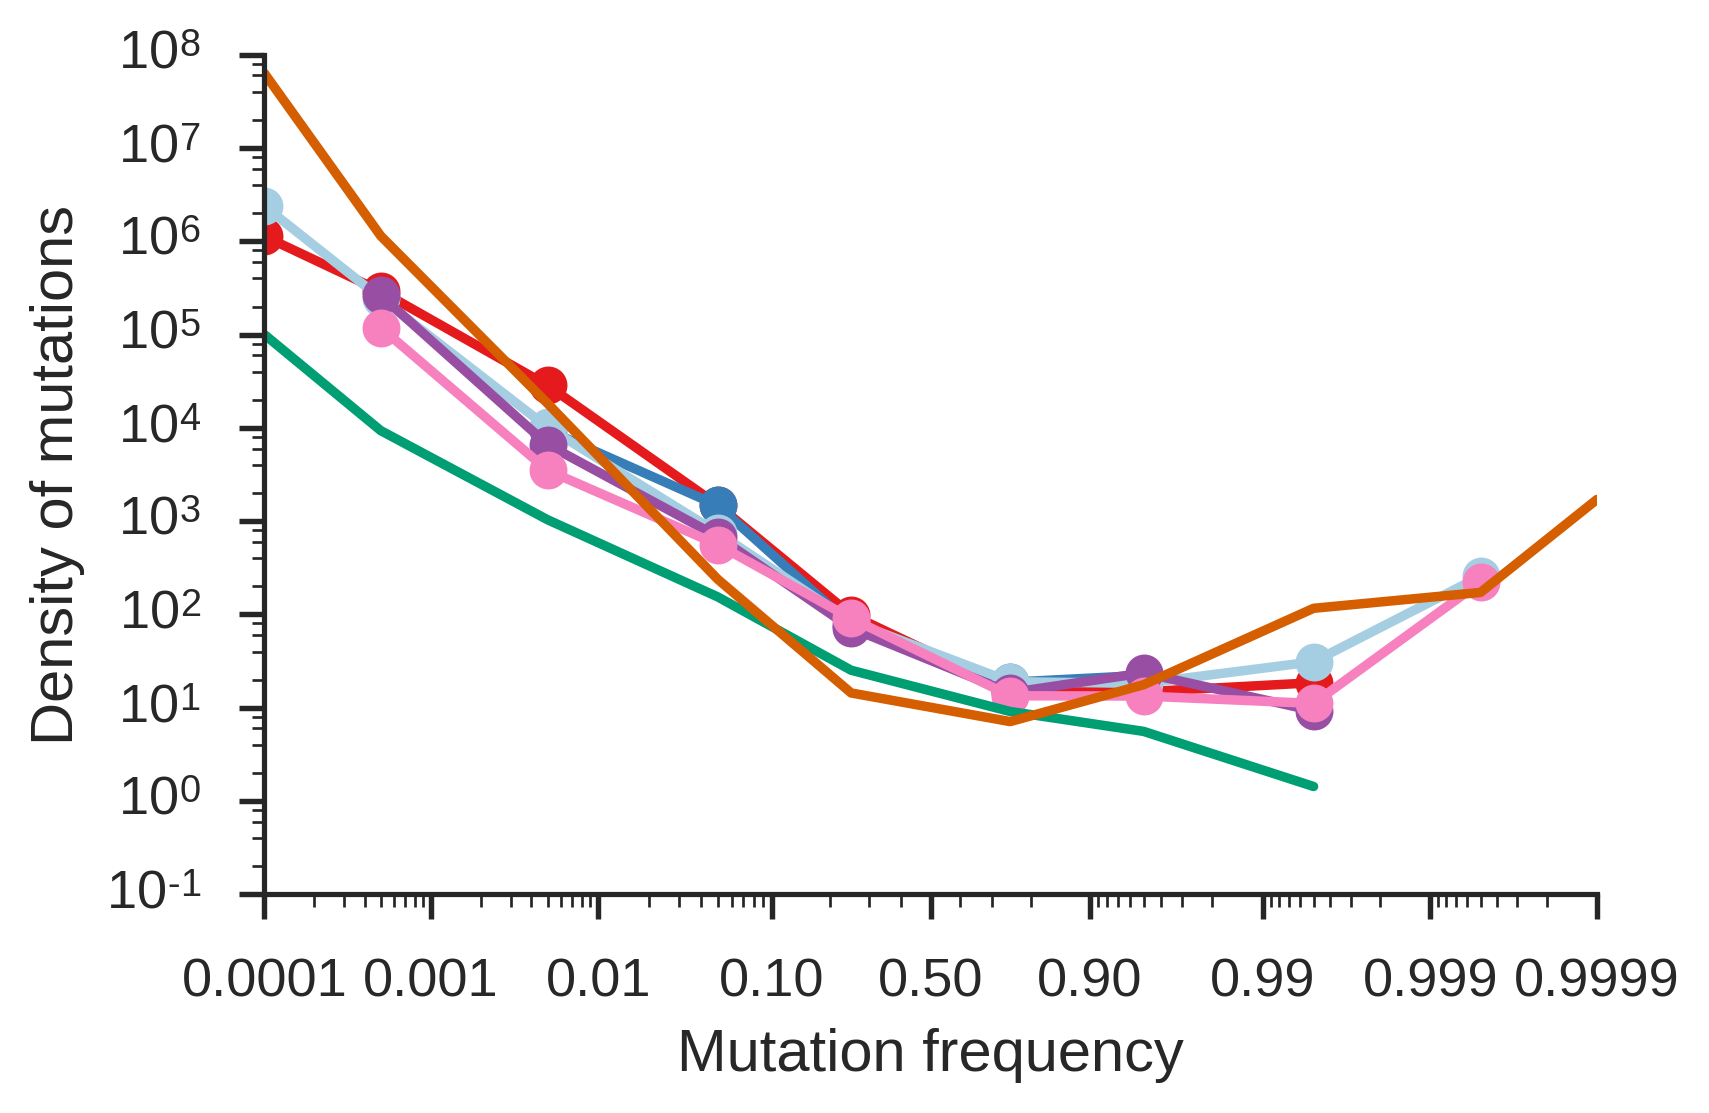

In [316]:
# Vaccine-responsive lineages
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for j, (patient_uid, group) in enumerate(df_expanded.groupby("patient_uid")):
    S = bct.calc_average_sfs(freqs, lineage_sizes, list(group.index), bins)
    bct.plot_sfs(ax, bin_centers_manual, S, marker="o", c=myColors_subjects[j],
             label=str(patient_uid_to_name[patient_uid]), zorder=0)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_BSC_mean*offset_sim, marker="", c=myColors[2], label="Continuous adaptation", zorder=2)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_kingman_mean*offset_sim, marker="", c=myColors[3], label="Neutral", zorder=1)
ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_Subjects_expanded", output_dir, output_suffix, output_formats, savefig_args)

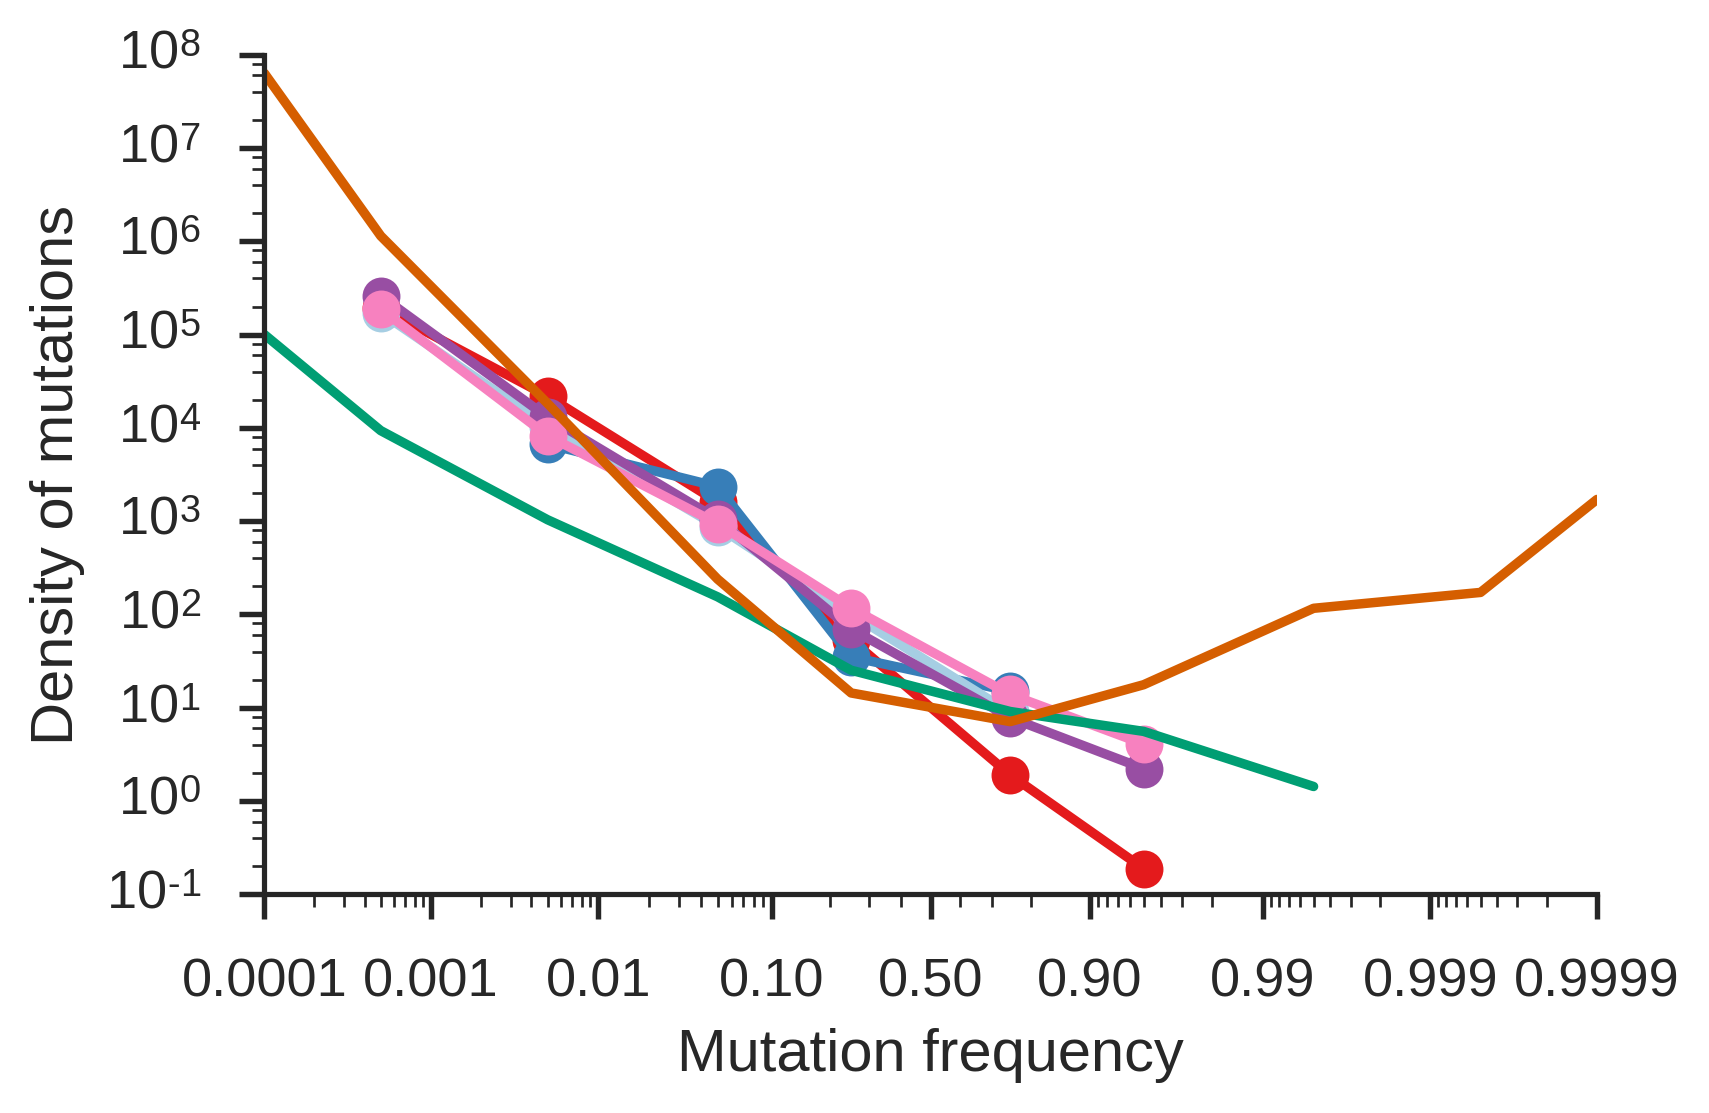

In [317]:
# Persistent
fig, ax = plt.subplots(1, 1, figsize=(6,4))
for j, (patient_uid, group) in enumerate(df_persistent.groupby("patient_uid")):
    S = bct.calc_average_sfs(freqs, lineage_sizes, list(group.index), bins)
    bct.plot_sfs(ax, bin_centers_manual, S, marker="o", c=myColors_subjects[j],
             label=str(patient_uid_to_name[patient_uid]), zorder=0)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_BSC_mean*offset_sim, marker="", c=myColors[2], label="Continuous adaptation", zorder=2)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_kingman_mean*offset_sim, marker="", c=myColors[3], label="Neutral", zorder=1)
ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_Subjects_persistent", output_dir, output_suffix, output_formats, savefig_args)

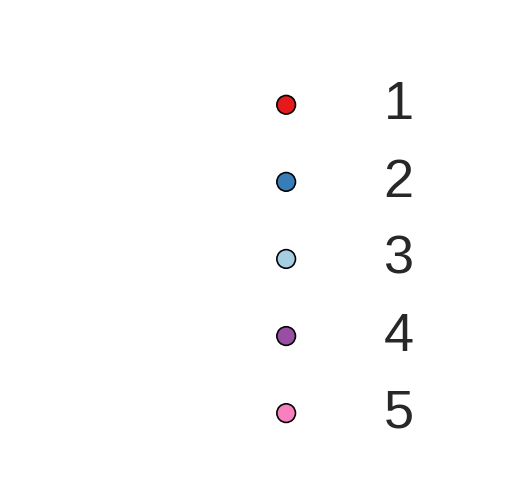

In [318]:
# Plot legend for subjects
myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
fig, ax = plt.subplots(1, 1, figsize=(1,1))
for i, c in enumerate(myColors_subjects):
    ax.scatter(0, 0, c=c, label=str(i+1))
ax.set_xlim(1,2)
ax.set_axis_off()
ax.legend()
save_figure(fig, "SFS_Bulk_Subjects_legend", output_dir, output_suffix, output_formats, savefig_args)

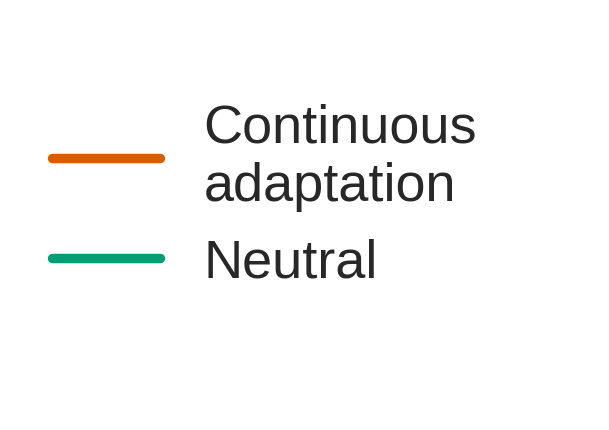

In [333]:
# Plot legend for models
fig, ax = plt.subplots(1, 1, figsize=(1,1))
ax.plot([0,1], [0,1], c=myColors[2], label="Continuous\nadaptation")
ax.plot([0,1], [0,1], c=myColors[3], label="Neutral")
ax.set_xlim(-2,-1)
ax.set_axis_off()
ax.legend()
save_figure(fig, "SFS_Bulk_Models_legend", output_dir, output_suffix, output_formats, savefig_args)

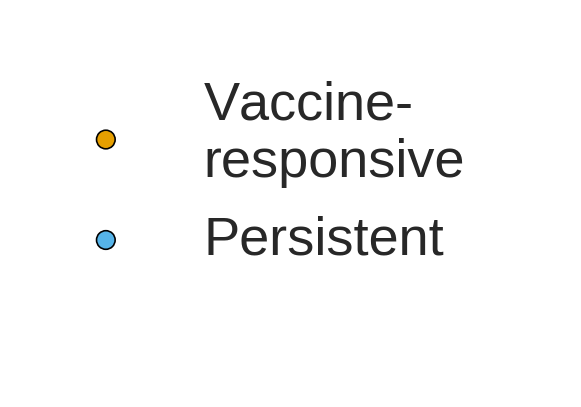

In [421]:
# Plot legend for averaged lineages
fig, ax = plt.subplots(1, 1, figsize=(1,1))
for c, label in zip(myColors, ["Vaccine-\nresponsive", "Persistent"]):
    ax.scatter(0, 0, c=c, label=label)
ax.set_xlim(1,2)
ax.set_axis_off()
ax.legend()
save_figure(fig, "SFS_Bulk_AllSubjects_legend", output_dir, output_suffix, output_formats, savefig_args)

# Plot SFS with error margins

In [319]:
def calc_average_sfs_with_sem(freqs, lineage_sizes, lineage_uids, bins):
    """ Calculate mean SFS over an ensemble by taking mean value at each bin """
    S = np.empty((len(lineage_uids), len(bins)-1))
    for i, lineage_uid in enumerate(lineage_uids):
        myFreqs = freqs[lineage_uid].values()
        myLeaves = lineage_sizes[lineage_uid]
        binned_sfs, binned_sfs_normed = bct.bin_sfs_cut(myFreqs, bins=bins, leaves=myLeaves)
        S[i,:] = binned_sfs_normed
    # S[S==0.0] = np.nan # before calculating mean, convert 0 to nan
    S_mean = np.nanmean(S, axis=0)
    S_sem = scipy.stats.sem(S, axis=0)
    return S_mean, S_sem

def mean_sem_to_error(y, dy):
    upper = y * (1.0 + dy/y)
    # lower = y * (1.0 - dy/y) # additive calculation
    lower = y * (y/upper) # symmetric error
    return np.array([upper, lower])

def drop_nan_errors(x, y, error):
    stacked = np.array([x, y, error[0,:], error[1,:]])
    # stacked_clean = stacked[:,~np.any(np.isnan(stacked), axis=0)] # drop x positions where any are nan
    stacked_clean = stacked[:,~np.any(stacked == 0, axis=0)] # drop x positions where any are 0
    # stacked_clean = stacked
    x_clean = stacked_clean[0,:]
    y_clean = stacked_clean[1,:]
    error_clean = stacked_clean[2:,:]
    return x_clean, y_clean, error_clean

def plot_sfs_fill(ax, bin_centers, binned_sfs, errors, p_min=1e-4, color="k", **kwargs):
    """ Plot SFS plus a filled region indicating the error bounds """
    
    # remove nan values
    X_clean, Y_clean, errors_clean = drop_nan_errors(bin_centers, binned_sfs, errors)
    
    ax.plot(X_clean, Y_clean, c=color, **kwargs)
    ax.fill_between(X_clean, errors_clean[0,:], errors_clean[1,:], color=color, alpha=0.2)
    
    ax.set_xscale("logit", p_min=p_min)
    ax.set_yscale("log")
    ax.set_xlabel("Mutation frequency")
    ax.set_ylabel("Density of mutations")
    sns.despine()
    plt.tight_layout()
    return ax

In [320]:
error_cap_widths_manual = dict(zip(bin_centers_manual, [1e-5, 1e-4, 0.5e-3, 0.5e-2, 2e-2,
                                                        2e-2, 0.5e-2, 0.5e-3, 1e-4, 1e-5]))

def plot_sfs_with_error_bars(ax, bin_centers, binned_sfs, errors, p_min=1e-4, color="k", jitter=False, **kwargs):
    
    X_clean, Y_clean = bct.drop_zeroes(bin_centers, binned_sfs)
    Y_clean = np.array(Y_clean)
    
    if jitter:
        jitter_mags = np.array([error_cap_widths_manual[x] for x in X_clean])
        jitters = np.random.rand() * jitter_mags * 3
        X_clean_jitter = X_clean + jitters
    else:
        X_clean_jitter = X_clean
    ax.plot(X_clean_jitter, Y_clean, c=color, **kwargs)
    
    # add error bars
    for x, x_jitter, y, y_upper, y_lower in zip(X_clean, X_clean_jitter, Y_clean, errors[0,:], errors[1,:]):
        cap_width = error_cap_widths_manual[x]
        # print x, y, y_upper, y_lower
        ax.plot([x_jitter, x_jitter], [y_upper, y_lower], color=color, linewidth=1)
        ax.plot([x_jitter-cap_width, x_jitter+cap_width], [y_upper, y_upper], color=color, linewidth=1)
        ax.plot([x_jitter-cap_width, x_jitter+cap_width], [y_lower, y_lower], color=color, linewidth=1)

    ax.set_xscale("logit", p_min=p_min)
    ax.set_yscale("log")
    ax.set_xlabel("Mutation frequency")
    ax.set_ylabel("Density of mutations")
    sns.despine()
    plt.tight_layout()
    return ax

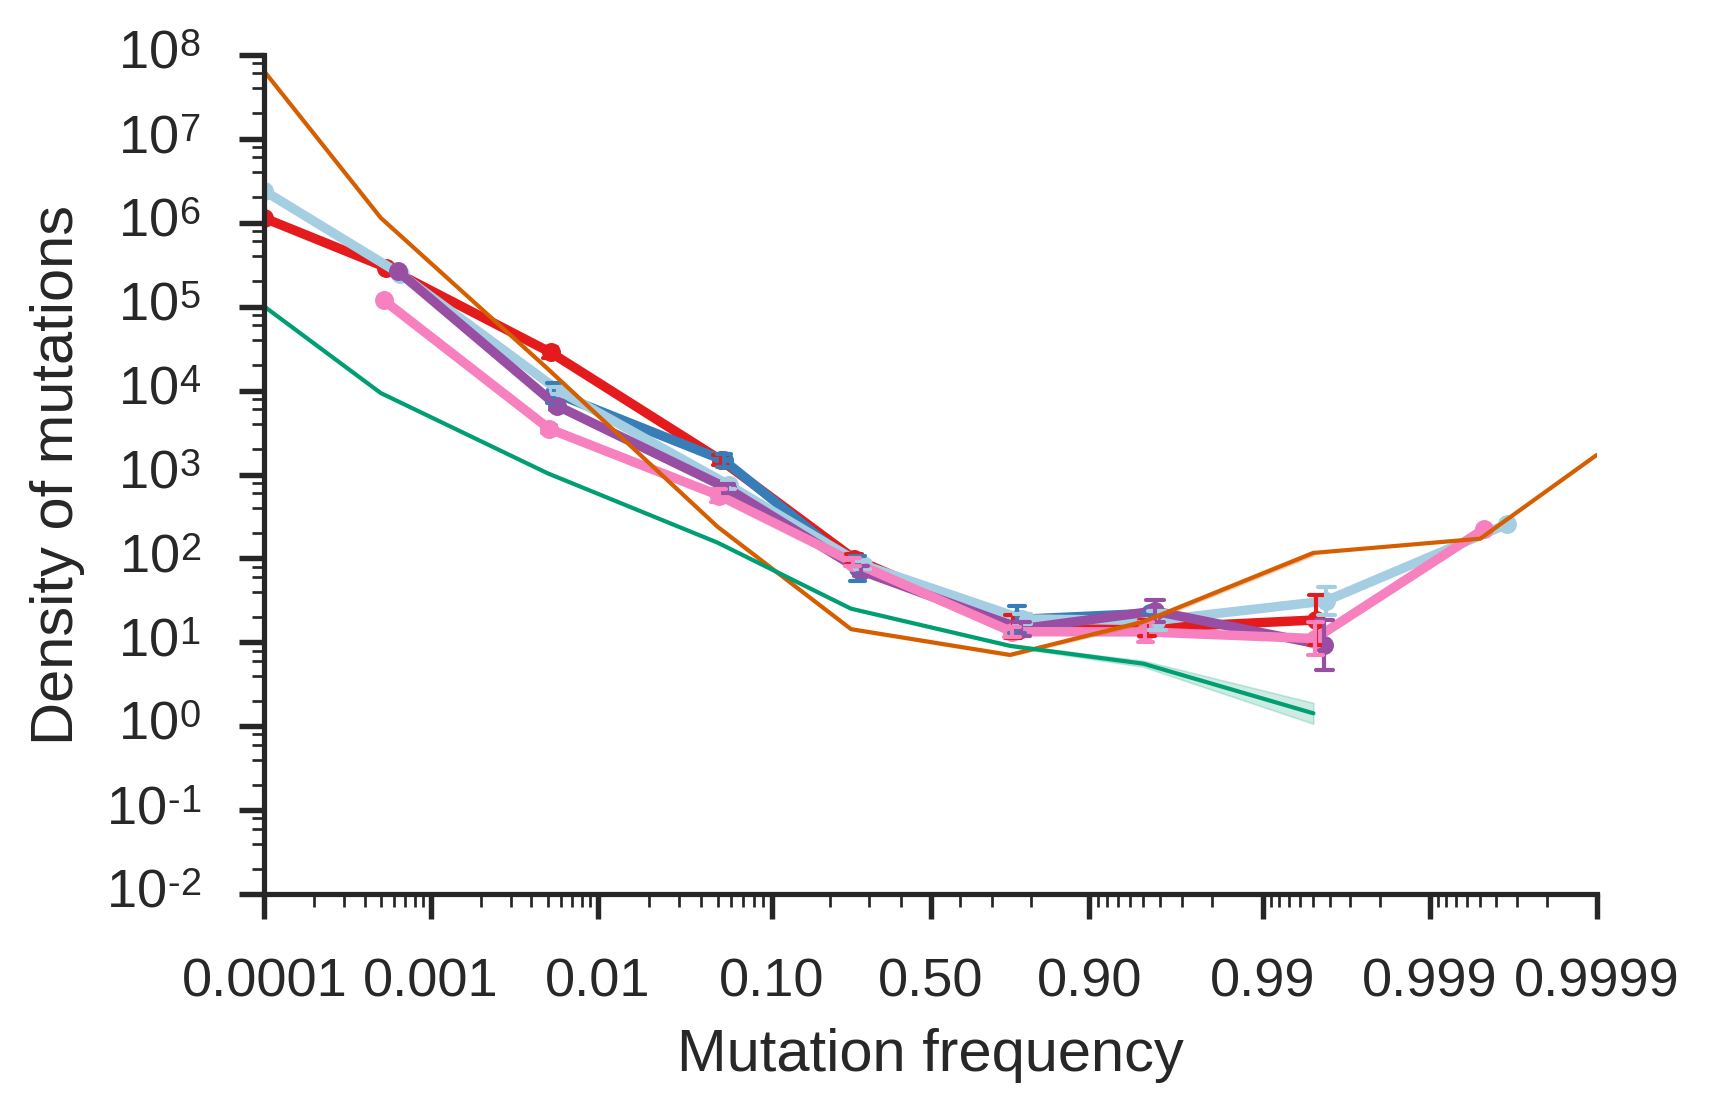

In [321]:
# Calculate average SFS over ensembles of lineages in each subject

fig, ax = plt.subplots(1, 1, figsize=(6,4))

for j, (patient_uid, group) in enumerate(df_expanded.groupby("patient_uid")):
    S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(group.index), bins)
    y = S_mean
    dy = S_sem
    error = mean_sem_to_error(y, dy)
    plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                             marker=".", color=myColors_subjects[j],
                             label=str(patient_uid_to_name[patient_uid]), zorder=0,
                             jitter=True)
    
y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-2, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_Subjects_expanded_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

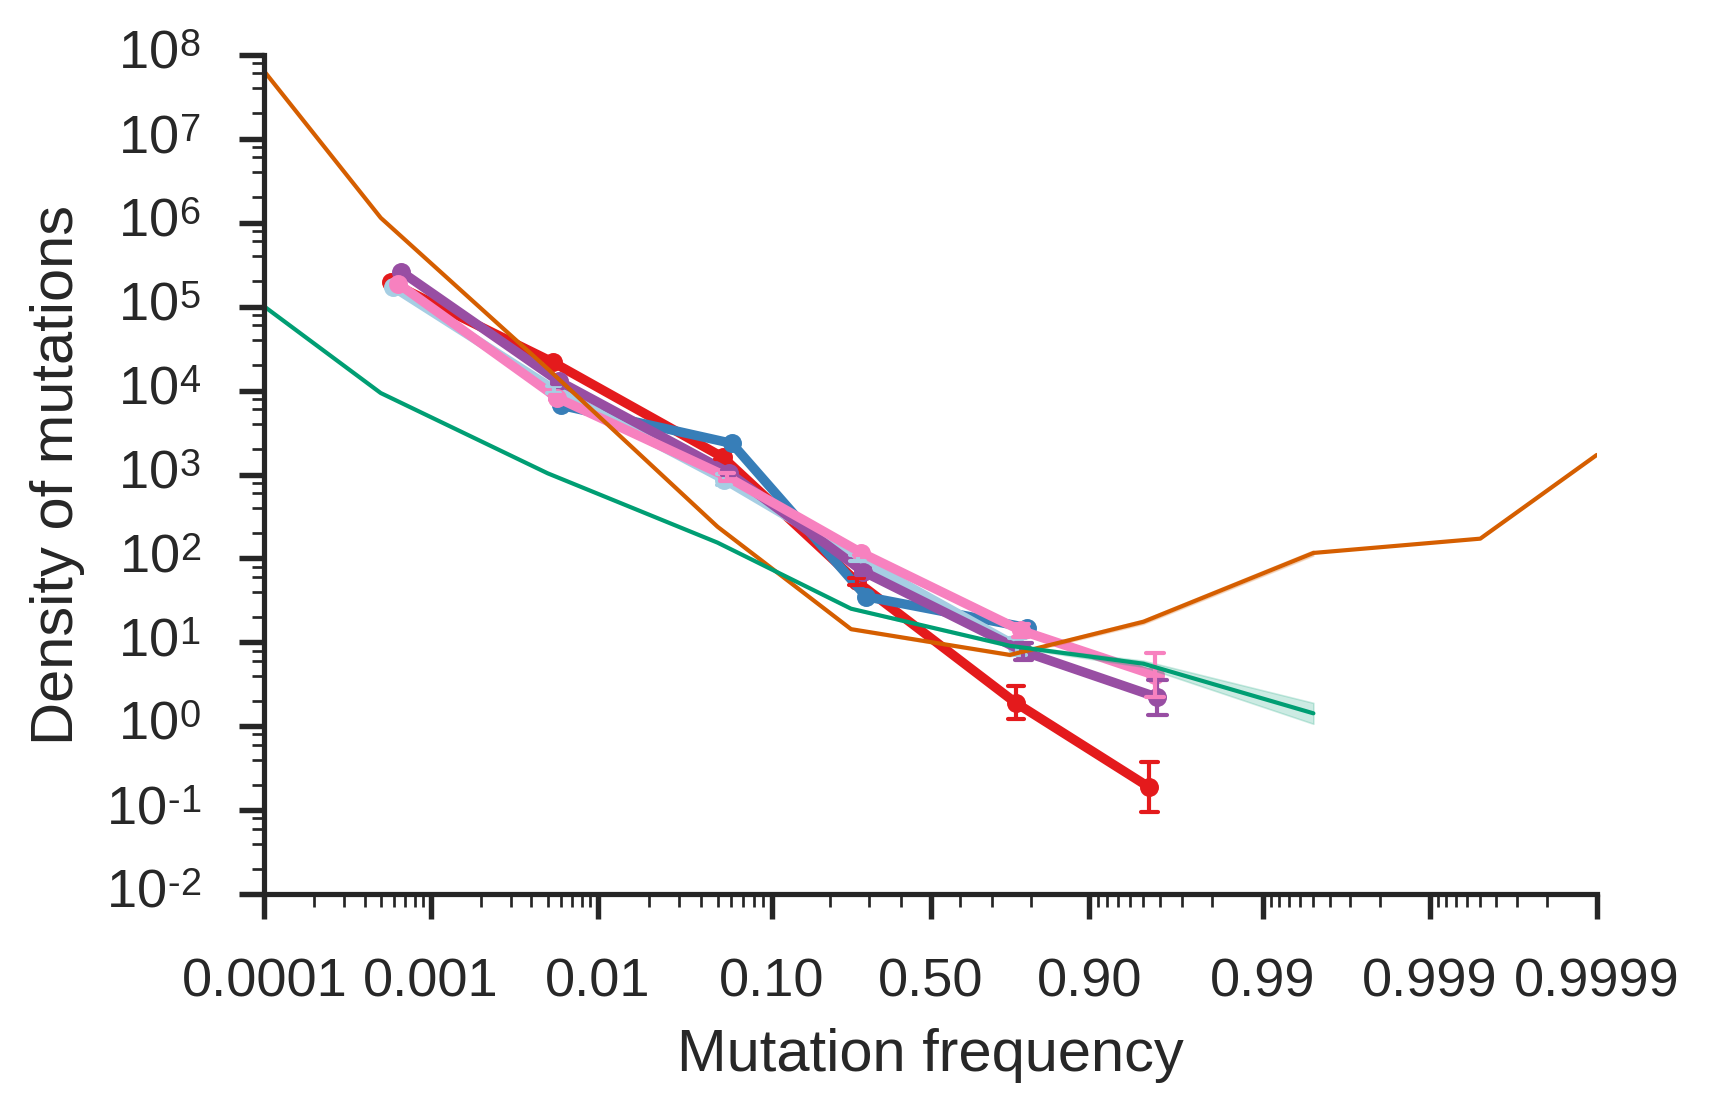

In [322]:
# Calculate average SFS over ensembles of lineages in each subject

myColors_subjects = ['#e41a1c','#377eb8','#a6cee3','#984ea3','#f781bf']
patient_uid_to_name = {2:1, 3:2, 6:3, 7:4, 8:5}

fig, ax = plt.subplots(1, 1, figsize=(6,4))

for j, (patient_uid, group) in enumerate(df_persistent.groupby("patient_uid")):
    S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(group.index), bins)
    y = S_mean
    dy = S_sem
    error = mean_sem_to_error(y, dy)
    plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                             marker=".", color=myColors_subjects[j],
                             label=str(patient_uid_to_name[patient_uid]), zorder=0,
                             jitter=True)
    
y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-2, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_Subjects_persistent_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

# Plot comparison with analytical scaling

In [323]:
# Calculate mean SFS across all subjects
S_expanded, S_expanded_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_expanded.index), bins)
S_persistent, S_persistent_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_persistent.index), bins)

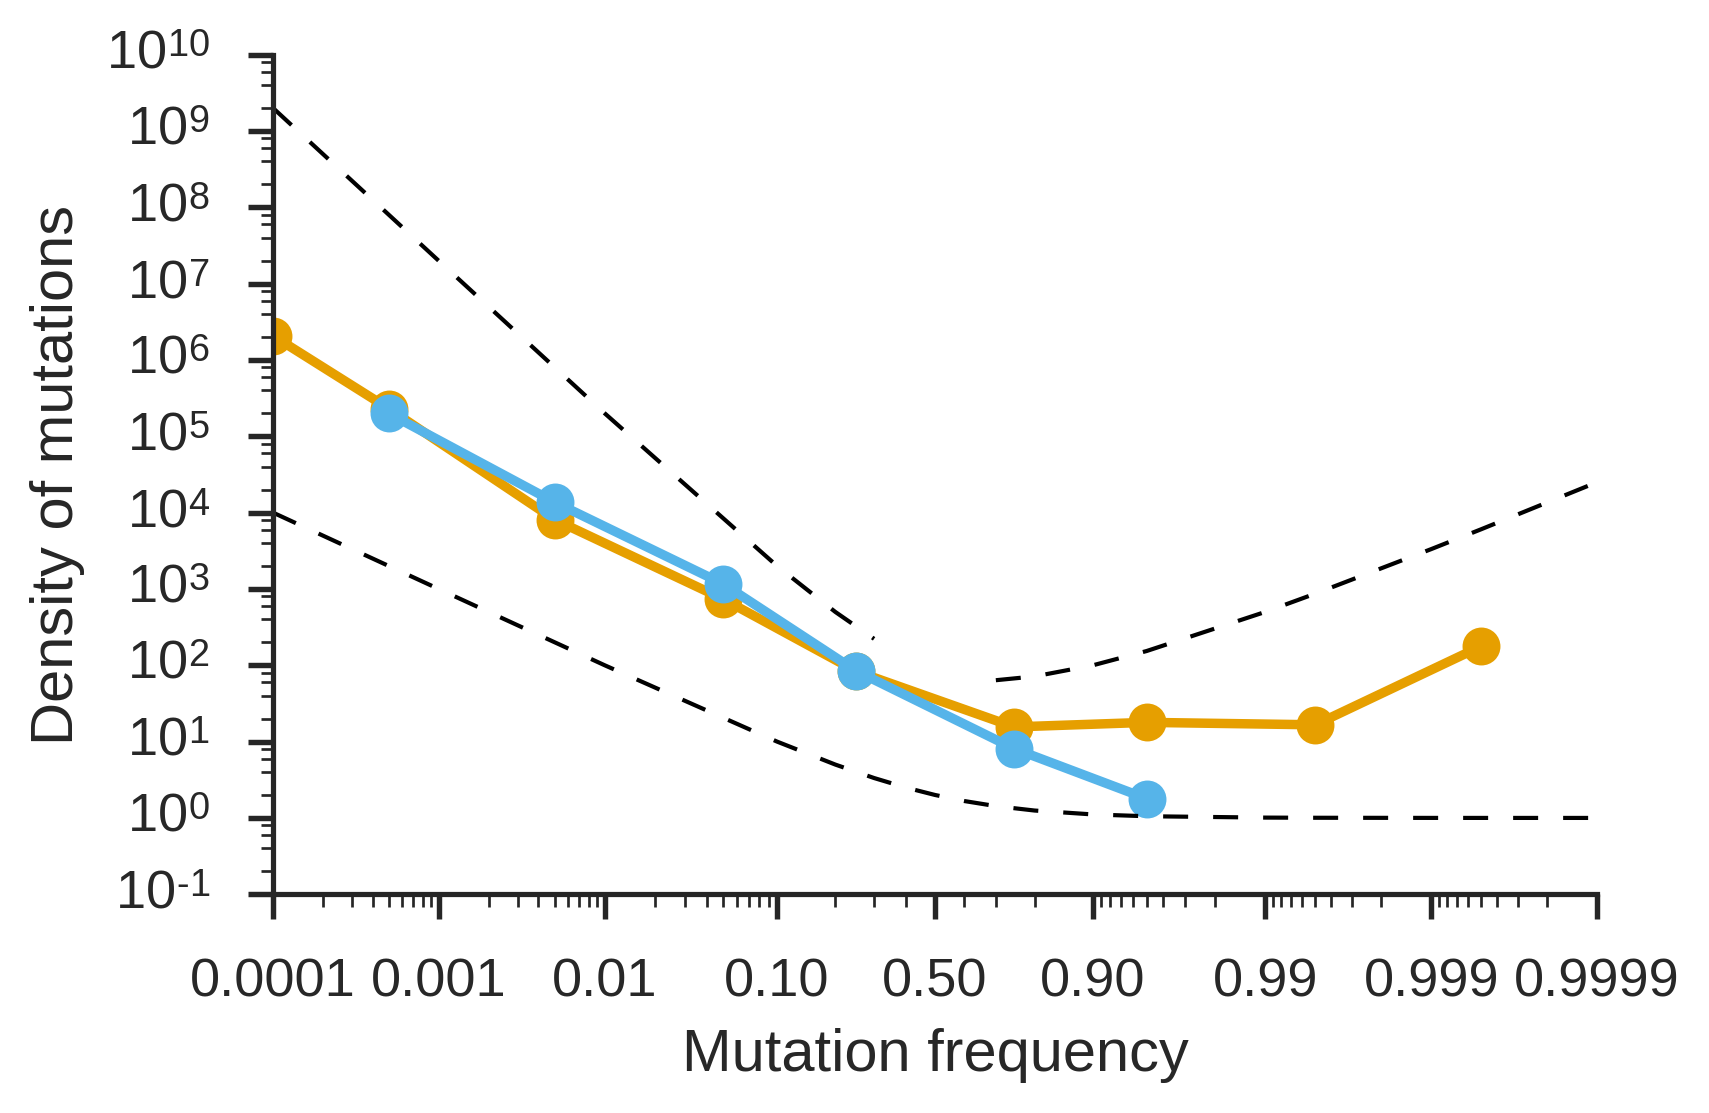

In [324]:
# Plot data with analytical scaling results

fig, ax = plt.subplots(1, 1, figsize=(6,4))

bct.plot_sfs(ax, bin_centers_manual, S_expanded, marker="o", c=myColors[0], label="Vaccine-responsive")
bct.plot_sfs(ax, bin_centers_manual, S_persistent, marker="o", c=myColors[1], label="Persistent")

# for j, (patient_uid, group) in enumerate(df_expanded.groupby("patient_uid")):
#     S_mean, S_sem = calc_average_sfs_with_sem(freqs, list(group.index), bins)
#     y = S_mean
#     dy = S_sem
#     error = mean_sem_to_error(y, dy)
#     plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
#                              marker=".", color=myColors_subjects[j],
#                              label=str(patient_uid_to_name[patient_uid]), zorder=0,
#                              jitter=True)
    
# y = sim_SFSs_BSC_mean * offset_sim
# dy = sim_SFSs_BSC_sem
# error = mean_sem_to_error(y, dy)
# plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
#               linewidth=1, color=myColors[2],
#               label="Continuous adaptation", zorder=2)

# y = sim_SFSs_kingman_mean * offset_sim
# dy = sim_SFSs_kingman_sem
# error = mean_sem_to_error(y, dy)
# plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
#               linewidth=1, color=myColors[3],
#               label="Neutral", zorder=2)

x_ana_hi = np.array([0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_hi = -1/((1-x_ana_hi)*np.log10(1-x_ana_hi)) * 10
ax.plot(x_ana_hi, y_ana_hi, color="k", linestyle="--", lw=1)

x_ana_lo = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3])
y_ana_lo = 1/x_ana_lo**2 * 20
ax.plot(x_ana_lo, y_ana_lo, color="k", linestyle="--", lw=1)

x_ana_kingman = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                             0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_kingman = 1/x_ana_kingman
ax.plot(x_ana_kingman, y_ana_kingman, color="k", linestyle="--", lw=1)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e10)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_analytical", output_dir, output_suffix, output_formats, savefig_args)

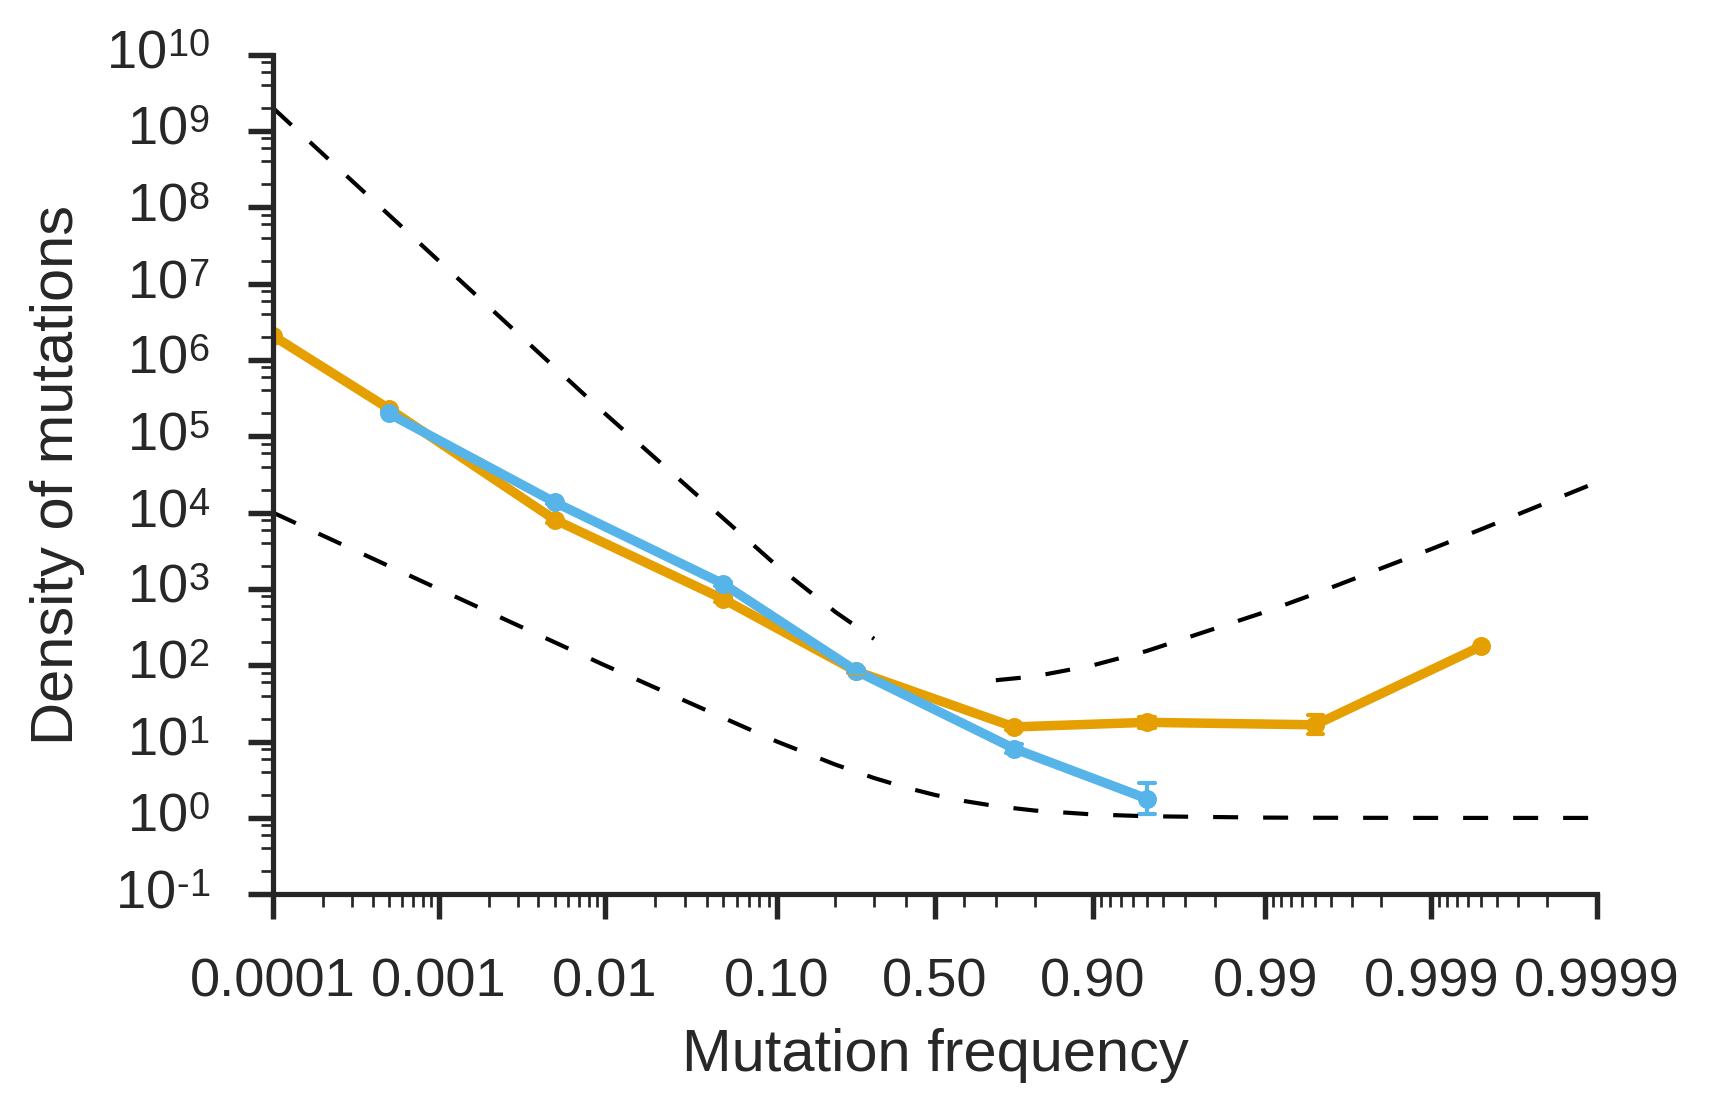

In [325]:
# Plot with error bars

fig, ax = plt.subplots(1, 1, figsize=(6,4))

y = S_expanded
dy = S_expanded_sem
error = mean_sem_to_error(y, dy)
plot_sfs_with_error_bars(ax, bin_centers_manual, S_expanded, error, 
                         marker=".", color=myColors[0], zorder=0,
                         jitter=False)

y = S_persistent
dy = S_persistent_sem
error = mean_sem_to_error(y, dy)
plot_sfs_with_error_bars(ax, bin_centers_manual, S_persistent, error, 
                         marker=".", color=myColors[1], zorder=0,
                         jitter=False)

# y = sim_SFSs_BSC_mean * offset_sim
# dy = sim_SFSs_BSC_sem
# error = mean_sem_to_error(y, dy)
# plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
#               linewidth=1, color=myColors[2],
#               label="Continuous adaptation", zorder=2)

# y = sim_SFSs_kingman_mean * offset_sim
# dy = sim_SFSs_kingman_sem
# error = mean_sem_to_error(y, dy)
# plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
#               linewidth=1, color=myColors[3],
#               label="Neutral", zorder=2)

x_ana_hi = np.array([0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_hi = -1/((1-x_ana_hi)*np.log10(1-x_ana_hi)) * 10
ax.plot(x_ana_hi, y_ana_hi, color="k", linestyle="--", lw=1)

x_ana_lo = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3])
y_ana_lo = 1/x_ana_lo**2 * 20
ax.plot(x_ana_lo, y_ana_lo, color="k", linestyle="--", lw=1)

x_ana_kingman = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                             0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_kingman = 1/x_ana_kingman
ax.plot(x_ana_kingman, y_ana_kingman, color="k", linestyle="--", lw=1)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e10)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_analytical_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

# Plot comparison with SFS under varying alpha

In [326]:
# Simulate SFS with varying alpha

sim_SFSs_varyingAlpha = {}

alphas = [1.2, 1.4, 1.6, 1.8]

for alpha in alphas:
    sim_SFSs_varyingAlpha[alpha] = simSFSs_sampleLineageSizes(lineage_sizes.values(), alpha=alpha,
                                                              nsample=100, bins=bins)

Elapsed time (wall clock): 33.8679420948
Elapsed time (wall clock): 13.869230032
Elapsed time (wall clock): 88.0032749176
Elapsed time (wall clock): 100.484929085


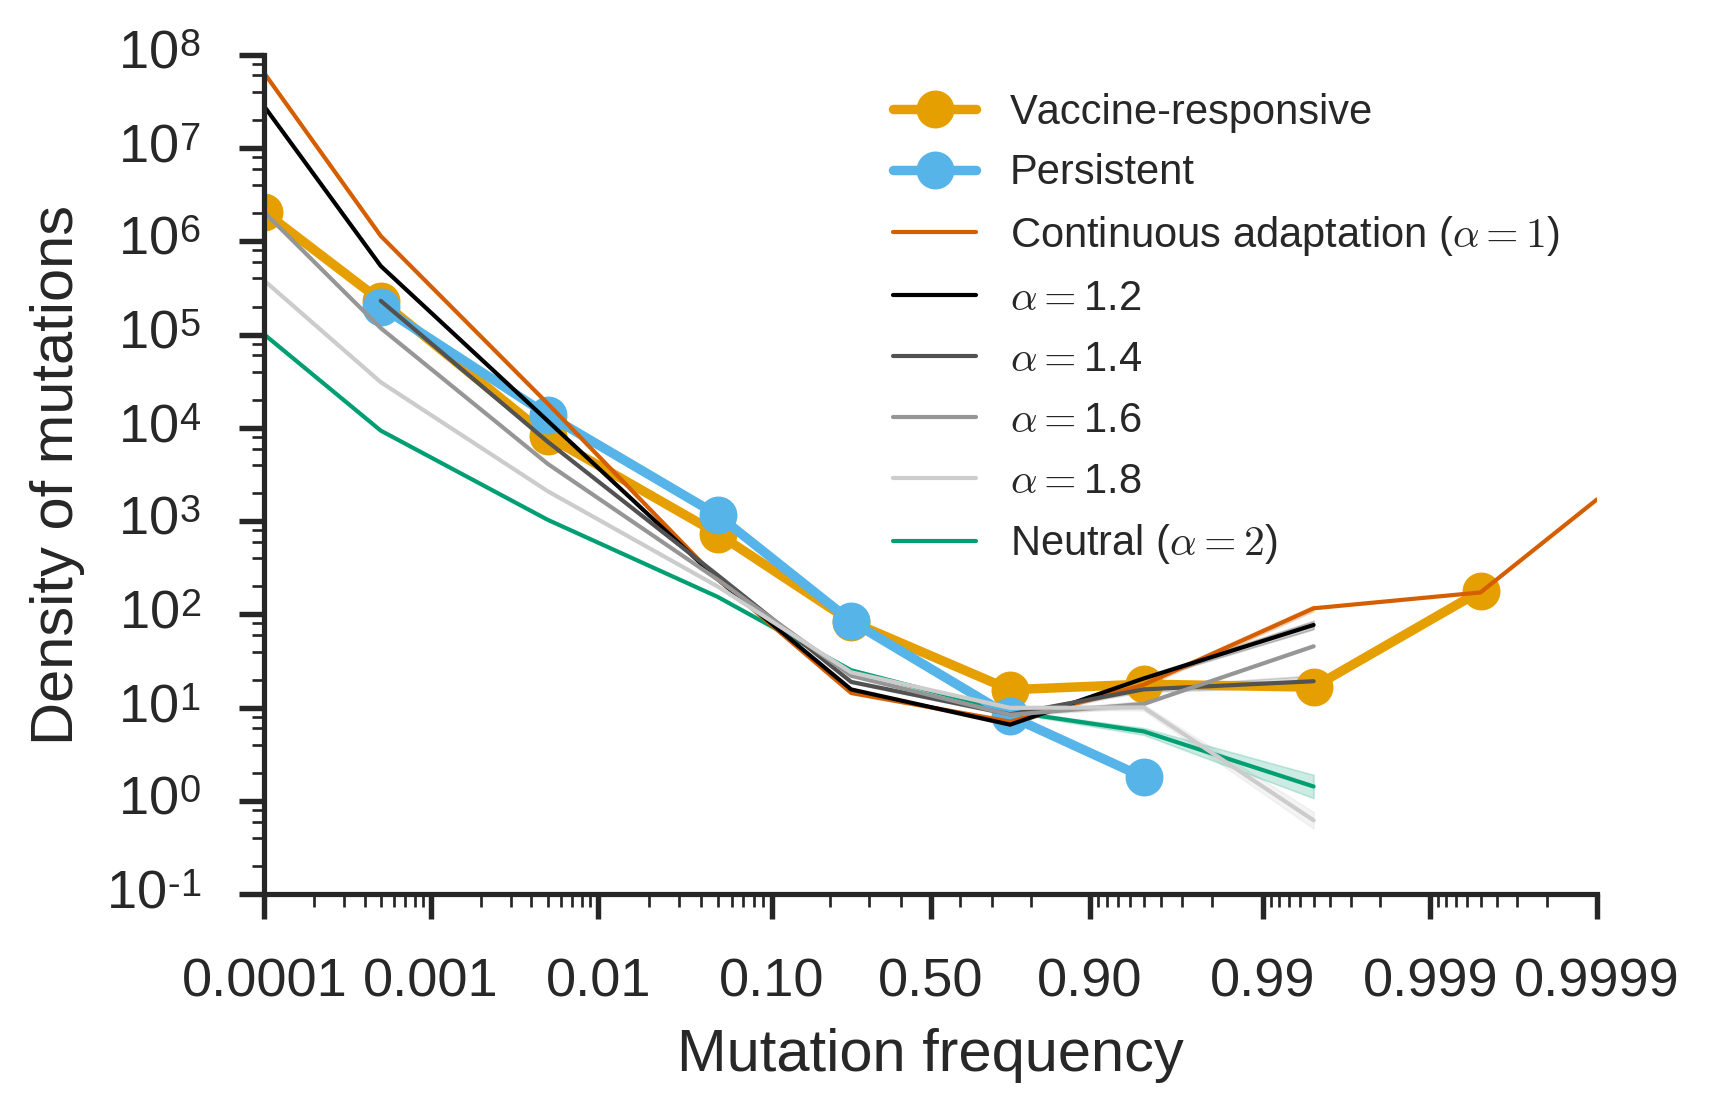

In [328]:
# Plot data with simulations from varying alpha

fig, ax = plt.subplots(1, 1, figsize=(6,4))

bct.plot_sfs(ax, bin_centers_manual, S_expanded, marker="o", c=myColors[0], label="Vaccine-responsive")
bct.plot_sfs(ax, bin_centers_manual, S_persistent, marker="o", c=myColors[1], label="Persistent")

# for j, (patient_uid, group) in enumerate(df_expanded.groupby("patient_uid")):
#     S_mean, S_sem = calc_average_sfs_with_sem(freqs, list(group.index), bins)
#     y = S_mean
#     dy = S_sem
#     error = mean_sem_to_error(y, dy)
#     plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
#                              marker=".", color=myColors_subjects[j],
#                              zorder=0,
#                              jitter=True)
    
y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
label = r'Continuous adaptation ($\alpha = 1$)'
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label=label, zorder=2)

colors = reversed(["#cccccc", "#969696", "#525252", "#000000"])
for alpha, color in zip(alphas, colors):
    
    my_sim_SFSs_mean, my_sim_SFSs_sem = bct.censor_mean_SFSs(sim_SFSs_varyingAlpha[alpha],
                                                             [x.n for x in sim_SFSs_varyingAlpha[alpha]], bins)
    y = my_sim_SFSs_mean * offset_sim
    dy = my_sim_SFSs_sem
    error = mean_sem_to_error(y, dy)
    label = r'$\alpha = $' + str(alpha)
    plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
                  linewidth=1, color=color,
                  label=label, zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
label = r'Neutral ($\alpha = 2$)'
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label=label, zorder=1)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)
ax.legend(loc="upper right", ncol=1, fontsize=10)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_varyingAlpha", output_dir, output_suffix, output_formats, savefig_args)

# Plot only models

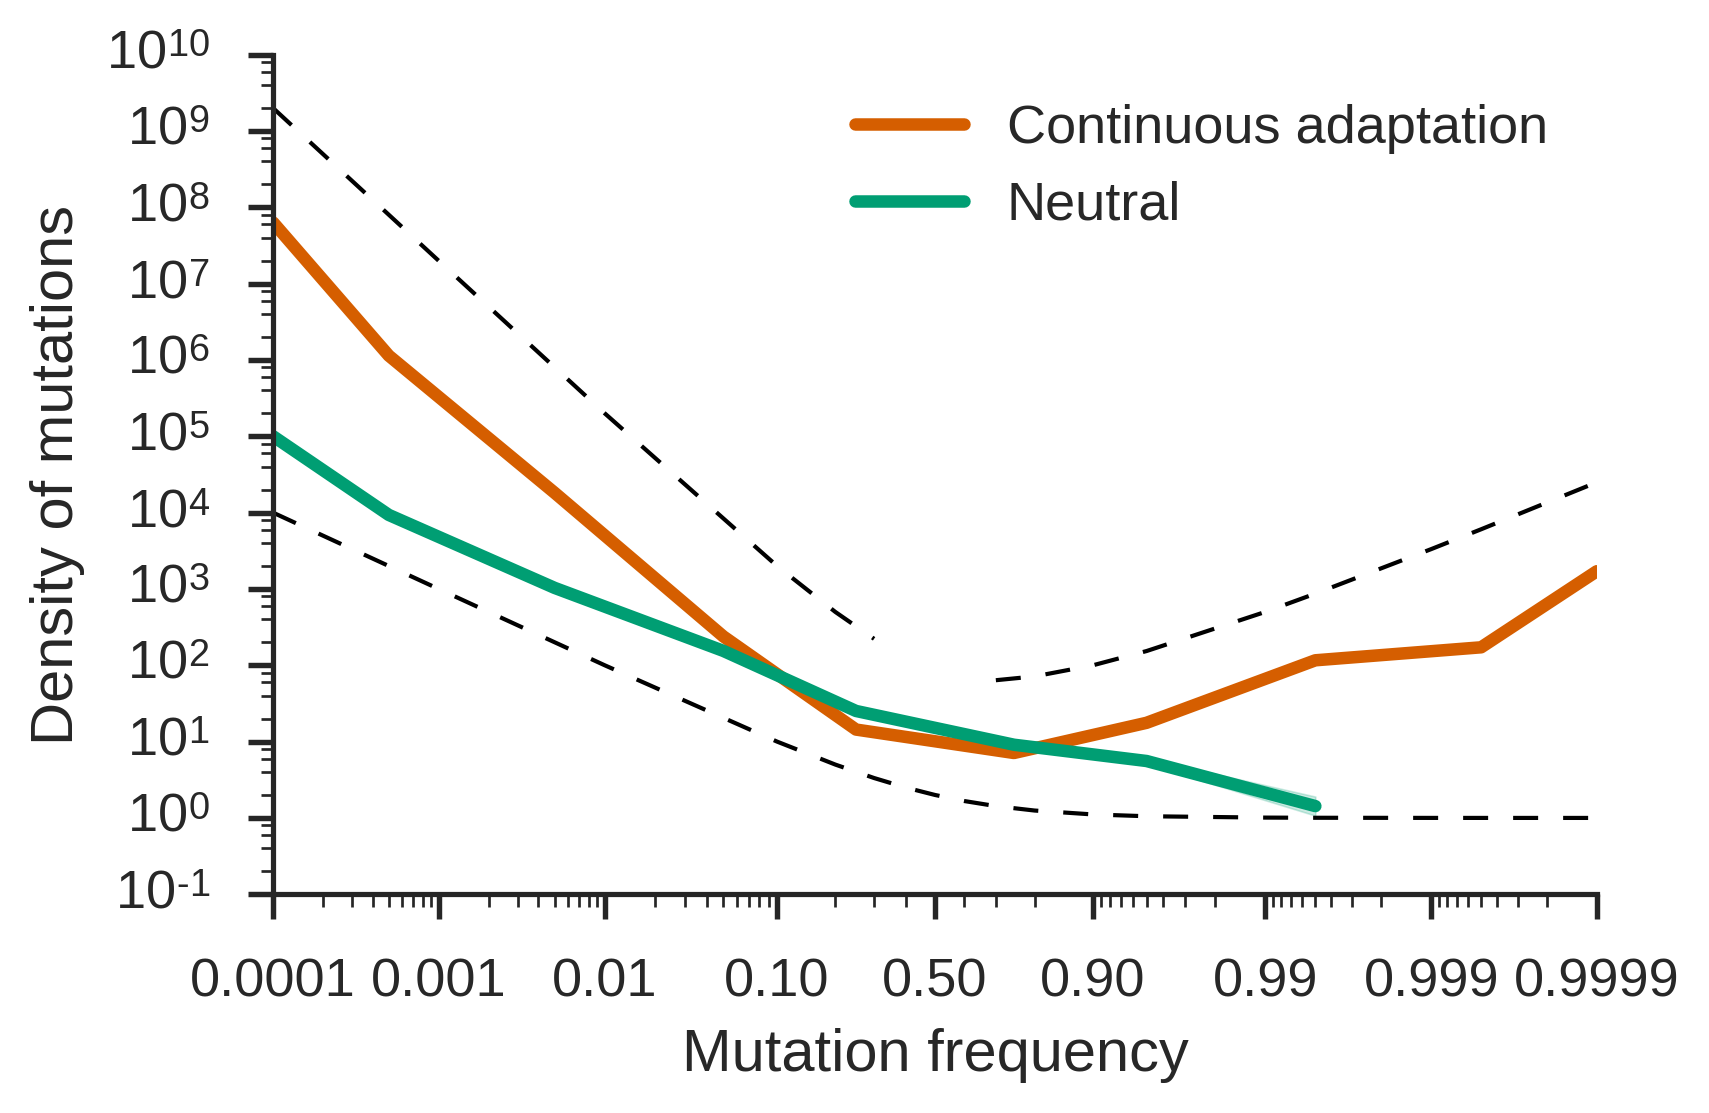

In [345]:
# Calculate average SFS over ensembles of lineages in each subject

fig, ax = plt.subplots(1, 1, figsize=(6,4))

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=3, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=3, color=myColors[3],
              label="Neutral", zorder=2)

x_ana_hi = np.array([0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_hi = -1/((1-x_ana_hi)*np.log10(1-x_ana_hi)) * 10
ax.plot(x_ana_hi, y_ana_hi, color="k", linestyle="--", lw=1)

x_ana_lo = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3])
y_ana_lo = 1/x_ana_lo**2 * 20
ax.plot(x_ana_lo, y_ana_lo, color="k", linestyle="--", lw=1)

x_ana_kingman = np.array([1e-4, 1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                             0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999])
y_ana_kingman = 1/x_ana_kingman
ax.plot(x_ana_kingman, y_ana_kingman, color="k", linestyle="--", lw=1)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e10)

ax.legend(loc="upper right", ncol=1)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_Models", output_dir, output_suffix, output_formats, savefig_args)

# Plot averages over all lineages, break to zero

In [407]:
offset_sim = 5

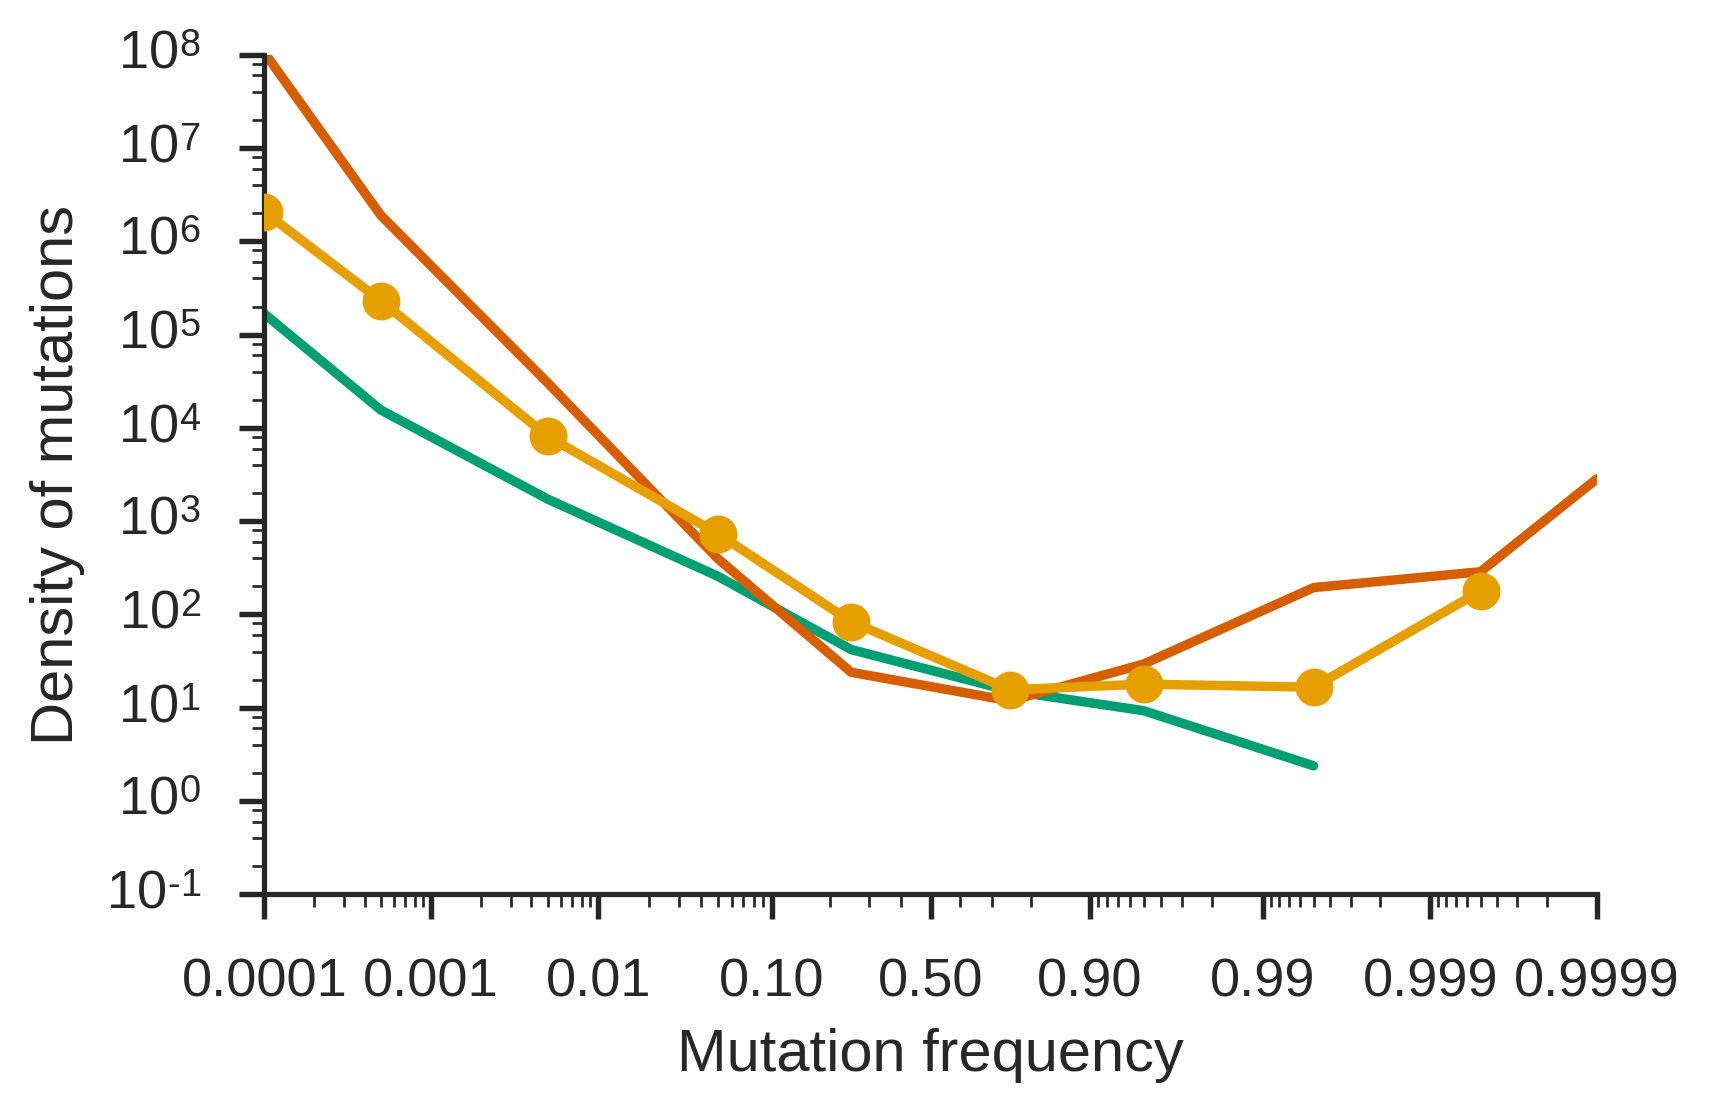

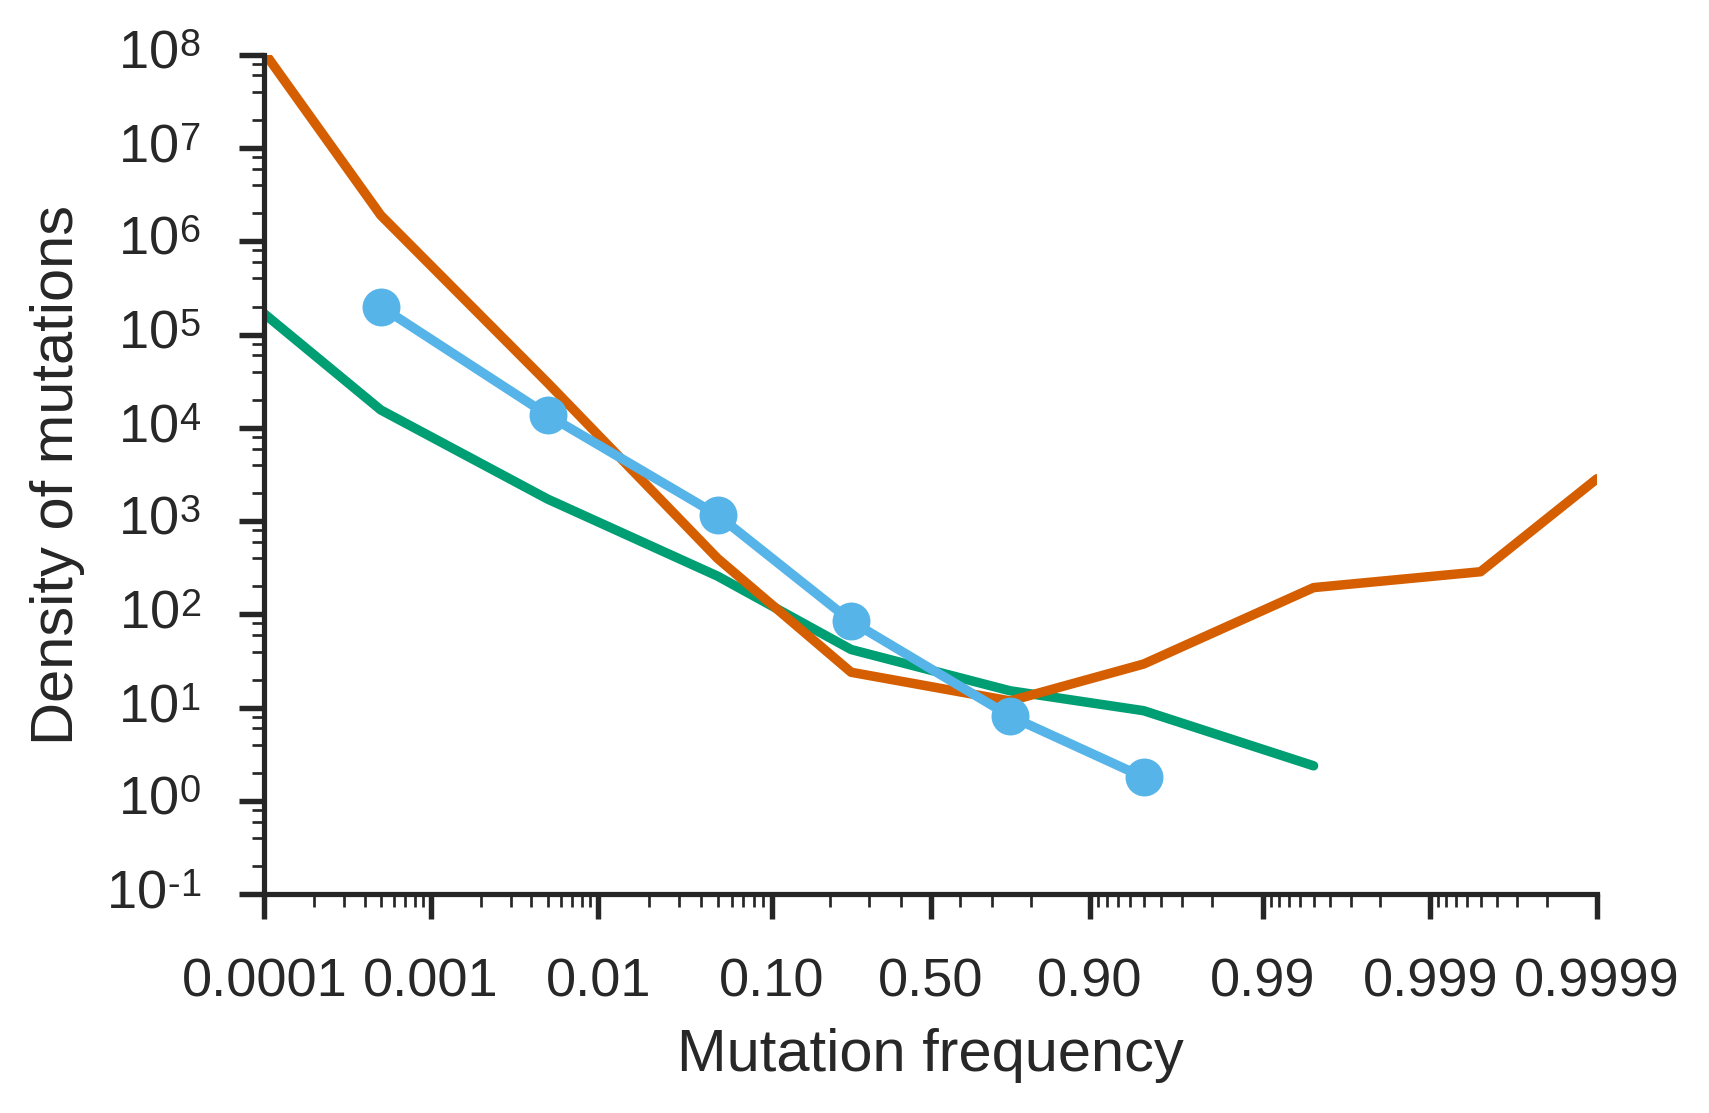

In [414]:
# No error bars

# Vaccine-responsive lineages
fig, ax = plt.subplots(1, 1, figsize=(6,4))
S = bct.calc_average_sfs(freqs, lineage_sizes, list(df_expanded.index), bins)
bct.plot_sfs(ax, bin_centers_manual, S, marker="o", c=myColors[0],
             label="Vaccine-responsive", zorder=10)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_BSC_mean*offset_sim, marker="", c=myColors[2], label="Continuous adaptation", zorder=2)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_kingman_mean*offset_sim, marker="", c=myColors[3], label="Neutral", zorder=1)
ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_expanded", output_dir, output_suffix, output_formats, savefig_args)


# Vaccine-responsive lineages
fig, ax = plt.subplots(1, 1, figsize=(6,4))
S = bct.calc_average_sfs(freqs, lineage_sizes, list(df_persistent.index), bins)
bct.plot_sfs(ax, bin_centers_manual, S, marker="o", c=myColors[1],
             label="Persistent", zorder=10)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_BSC_mean*offset_sim, marker="", c=myColors[2], label="Continuous adaptation", zorder=2)
bct.plot_sfs(ax, bin_centers_manual, sim_SFSs_kingman_mean*offset_sim, marker="", c=myColors[3], label="Neutral", zorder=1)
ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_persistent", output_dir, output_suffix, output_formats, savefig_args)

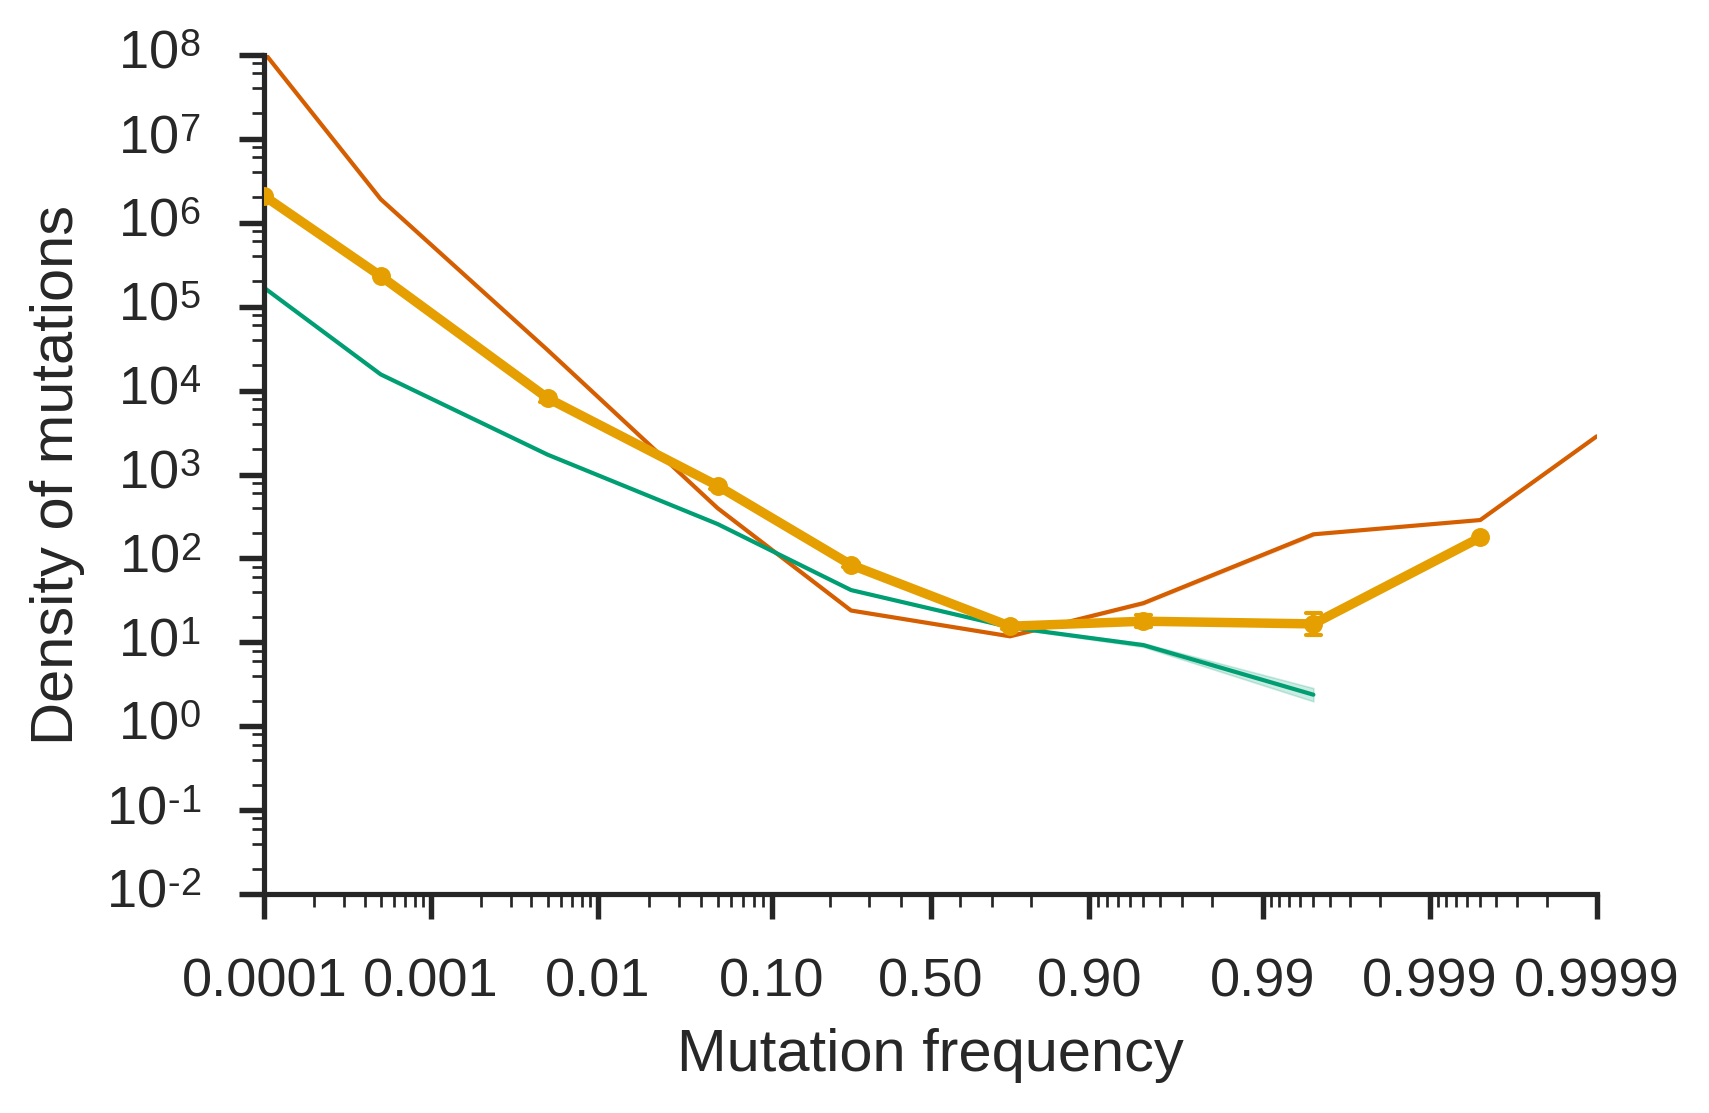

In [415]:
# Error bars, no break

fig, ax = plt.subplots(1, 1, figsize=(6,4))

S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_expanded.index), bins)
y = S_mean
dy = S_sem
error = mean_sem_to_error(y, dy)
plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                         marker=".", color=myColors[0],
                         label="Vaccine-responsive", zorder=10,
                         jitter=False)

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-2, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_expanded_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

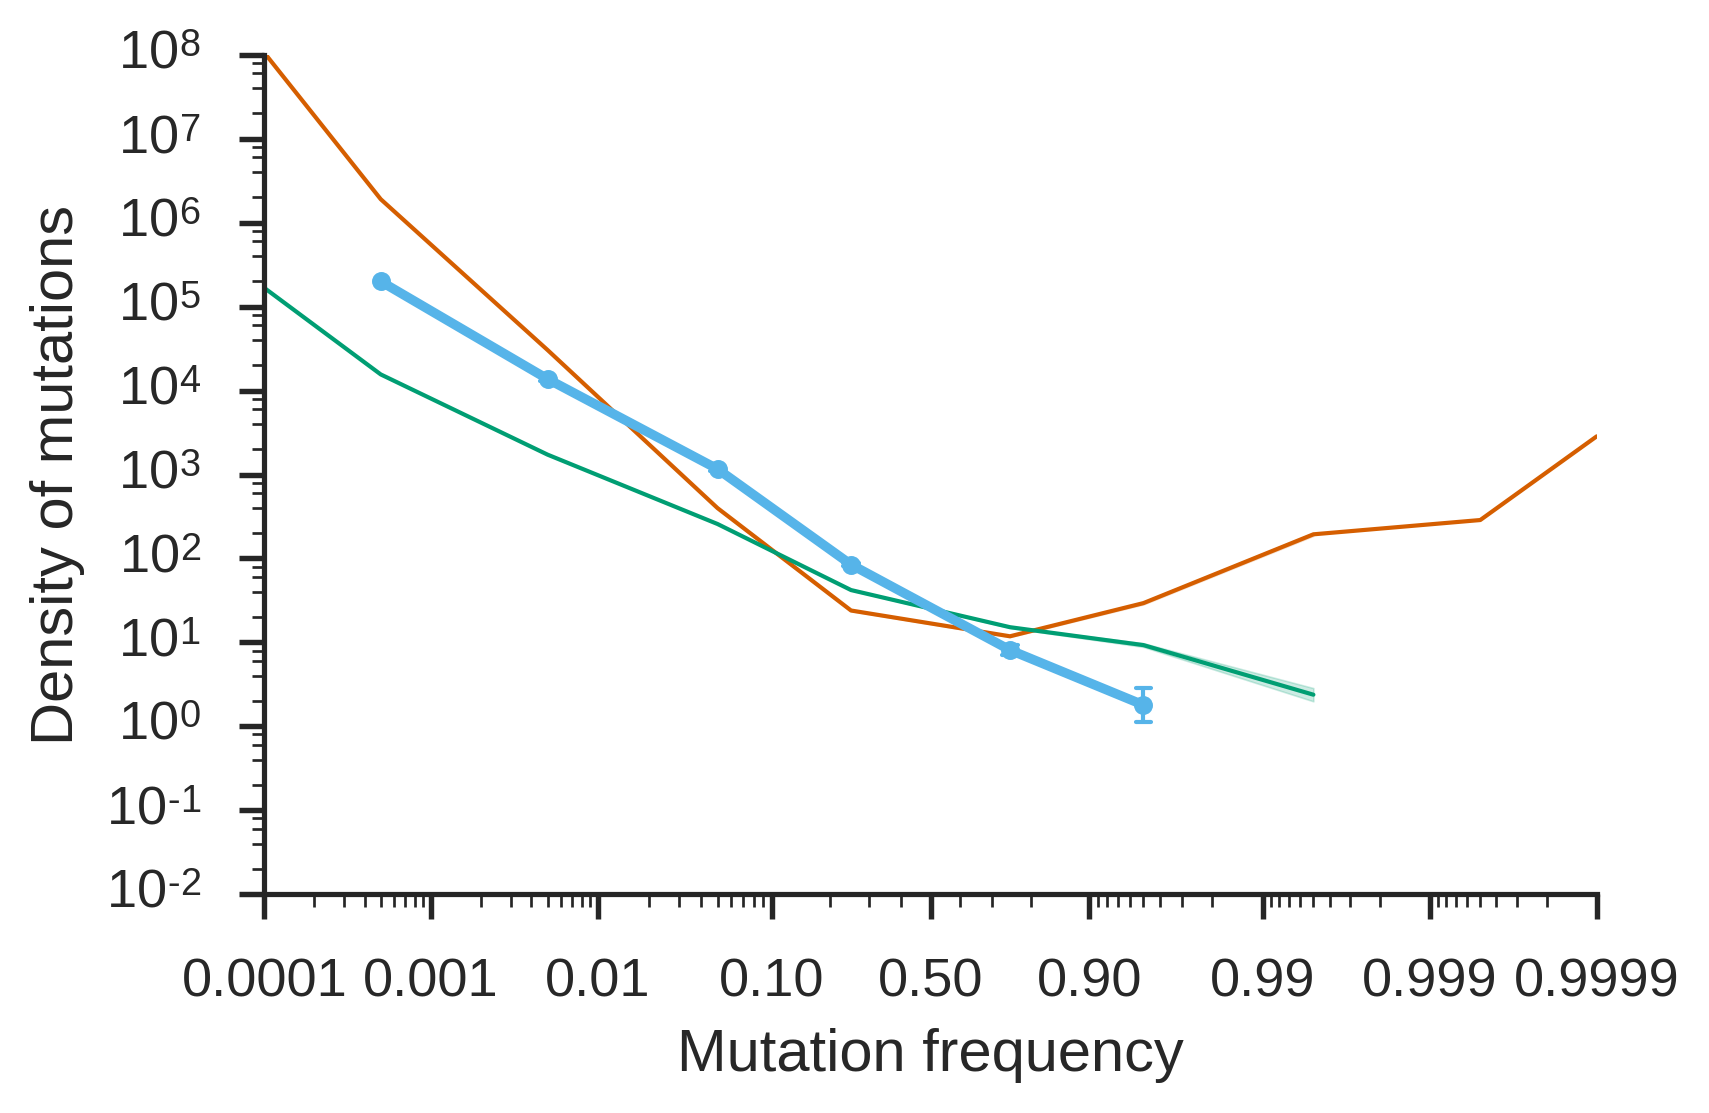

In [416]:
# Error bars, no break

fig, ax = plt.subplots(1, 1, figsize=(6,4))

S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_persistent.index), bins)
y = S_mean
dy = S_sem
error = mean_sem_to_error(y, dy)
plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                         marker=".", color=myColors[1],
                         label="Persistent", zorder=10,
                         jitter=False)

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-2, 1e8)
# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_persistent_ErrorBars", output_dir, output_suffix, output_formats, savefig_args)

# Add break to zero

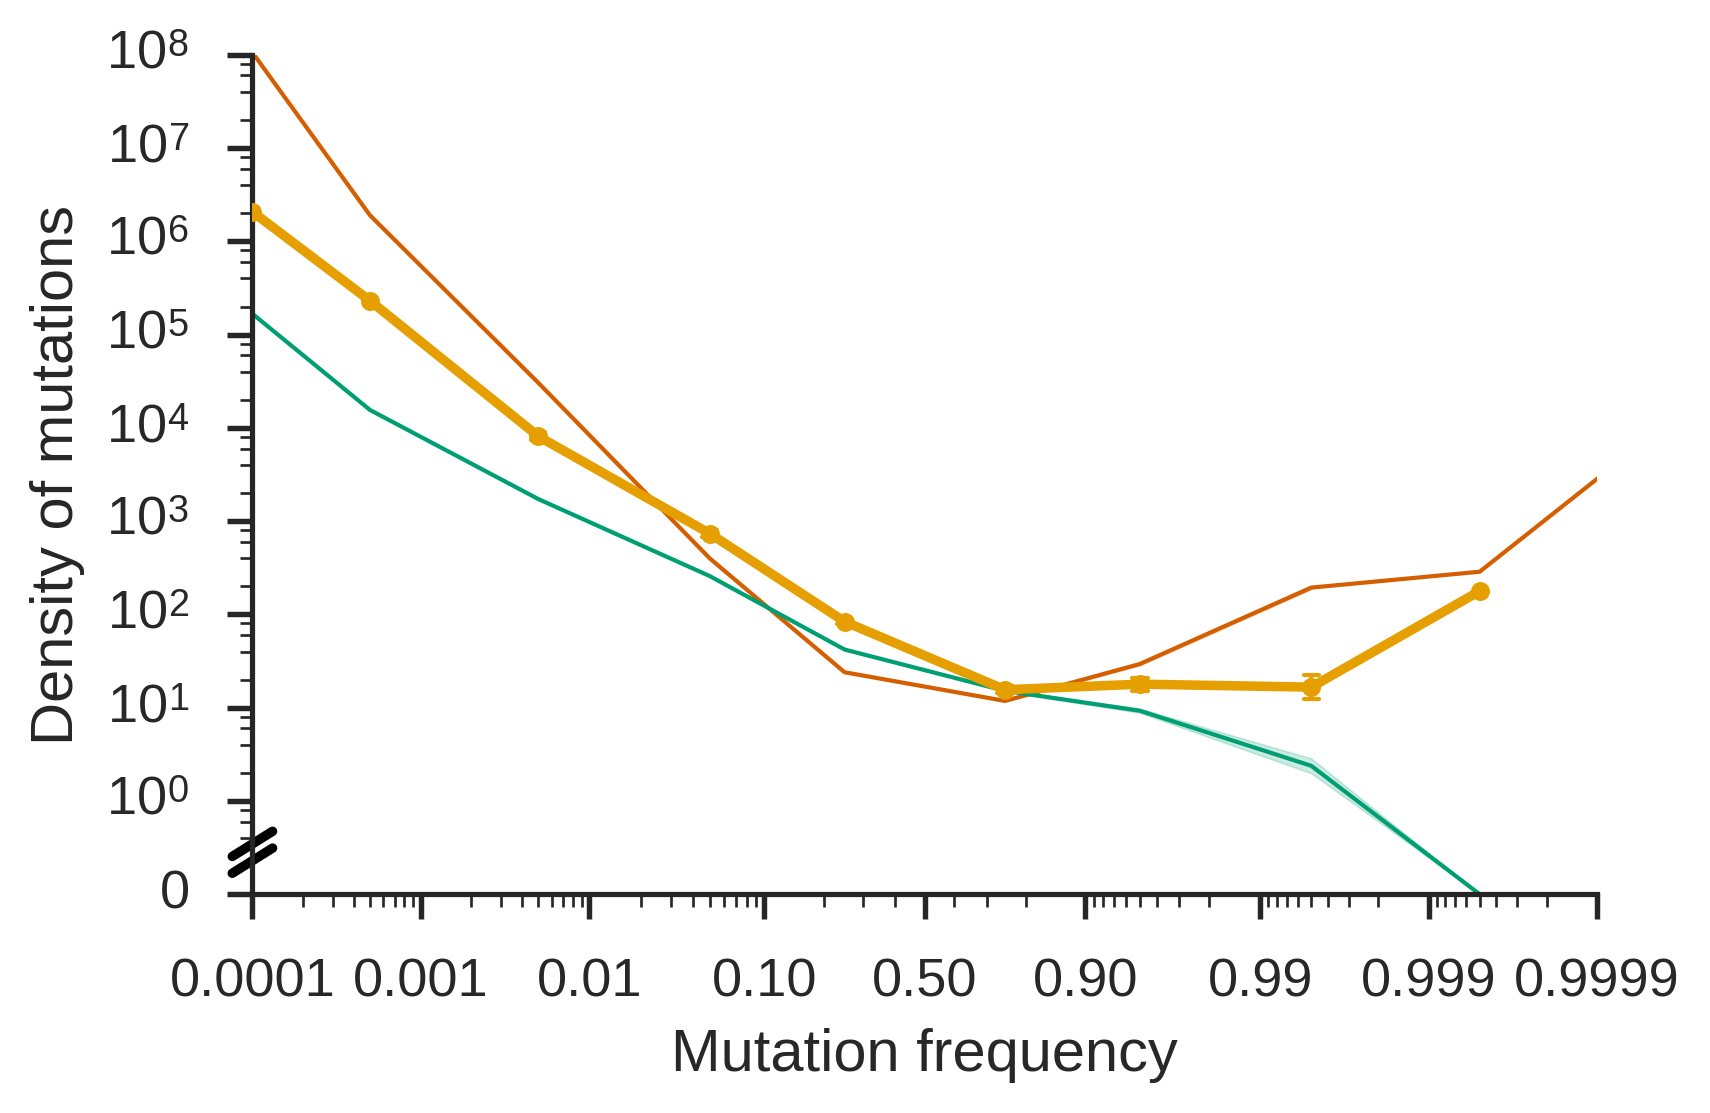

In [417]:
# Error bars, break

fig, ax = plt.subplots(1, 1, figsize=(6,4))

S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_expanded.index), bins)
y = S_mean
dy = S_sem
error = mean_sem_to_error(y, dy)
# S_mean[S_mean == 0.0] = 1e-3 # set zero values to low value, change label
plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                         marker=".", color=myColors[0],
                         label="Vaccine-responsive", zorder=10,
                         jitter=False)

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
error[0,-2] = 1e-1
error[1,-2] = 1e-1
y[y == 0.0] = 1e-1
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)

# break in plot
# yticklabels = ax.get_yticklabels()
# yticklabels[1] = "0"

# have to set labels by brute force because it was fucking up
yticklabels = [u'', u'$\\mathdefault{10^{-1}}$', u'$\\mathdefault{10^{0}}$', u'$\\mathdefault{10^{1}}$', u'$\\mathdefault{10^{2}}$', u'$\\mathdefault{10^{3}}$', u'$\\mathdefault{10^{4}}$', u'$\\mathdefault{10^{5}}$', u'$\\mathdefault{10^{6}}$', u'$\\mathdefault{10^{7}}$', u'$\\mathdefault{10^{8}}$', u'']
yticklabels[1]= "0"
ax.set_yticklabels(yticklabels)

d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k',
              clip_on=False) # arguments to pass to plot
ax.plot((-d, +d), (-d+6e-2, +d+6e-2), **kwargs)        # top diagonal
ax.plot((-d, +d), (-d+4e-2, +d+4e-2), **kwargs)        # bottom diagonal

# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_expanded_ErrorBars_Break", output_dir, output_suffix, output_formats, savefig_args)

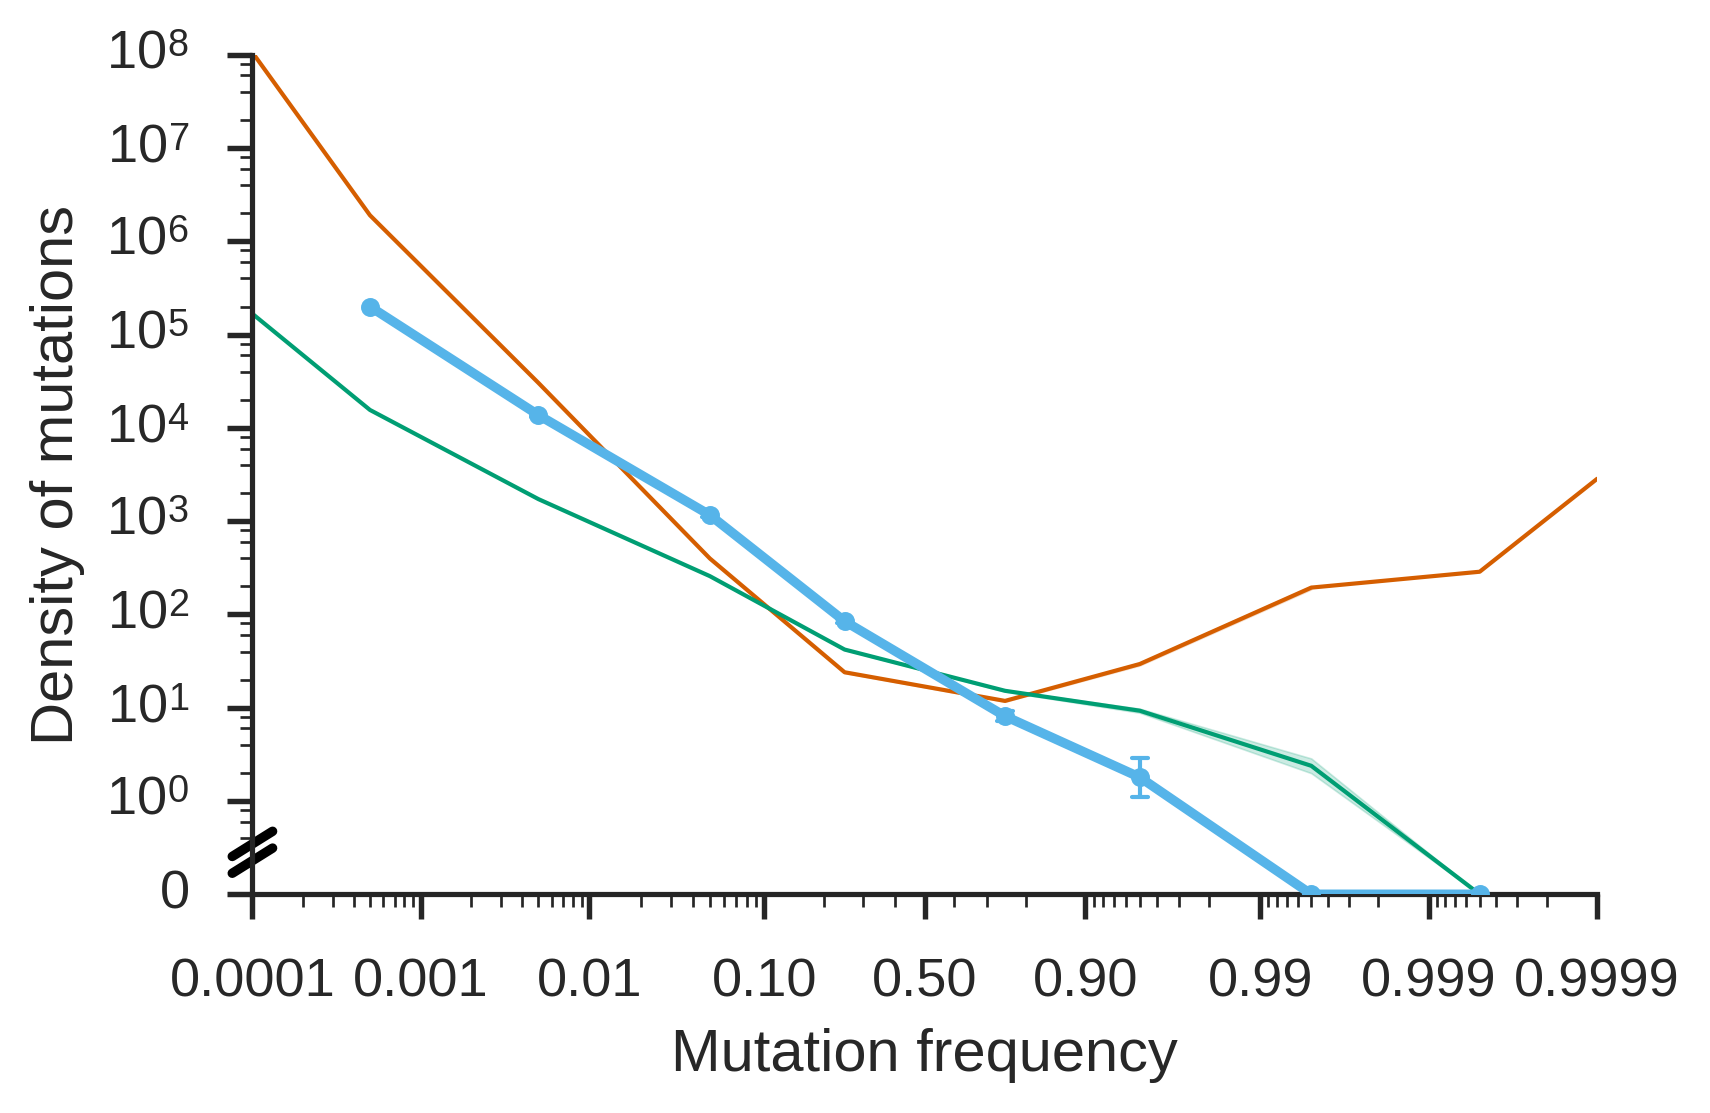

In [418]:
# Error bars, break

fig, ax = plt.subplots(1, 1, figsize=(6,4))

S_mean, S_sem = calc_average_sfs_with_sem(freqs, lineage_sizes, list(df_persistent.index), bins)
y = S_mean
dy = S_sem
error = mean_sem_to_error(y, dy)
S_mean[S_mean == 0.0] = 1e-1 # set zero values to low value, change label
plot_sfs_with_error_bars(ax, bin_centers_manual, S_mean, error, 
                         marker=".", color=myColors[1],
                         label="Persistent", zorder=10,
                         jitter=False)

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
error[0,-2] = 1e-1
error[1,-2] = 1e-1
y[y == 0.0] = 1e-1
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)

# break in plot
yticklabels = ax.get_yticklabels()
yticklabels[1] = "0"
ax.set_yticklabels(yticklabels)
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False) # arguments to pass to plot
ax.plot((-d, +d), (-d+6e-2, +d+6e-2), **kwargs)        # top diagonal
ax.plot((-d, +d), (-d+4e-2, +d+4e-2), **kwargs)        # bottom diagonal

# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_persistent_ErrorBars_Break", output_dir, output_suffix, output_formats, savefig_args)

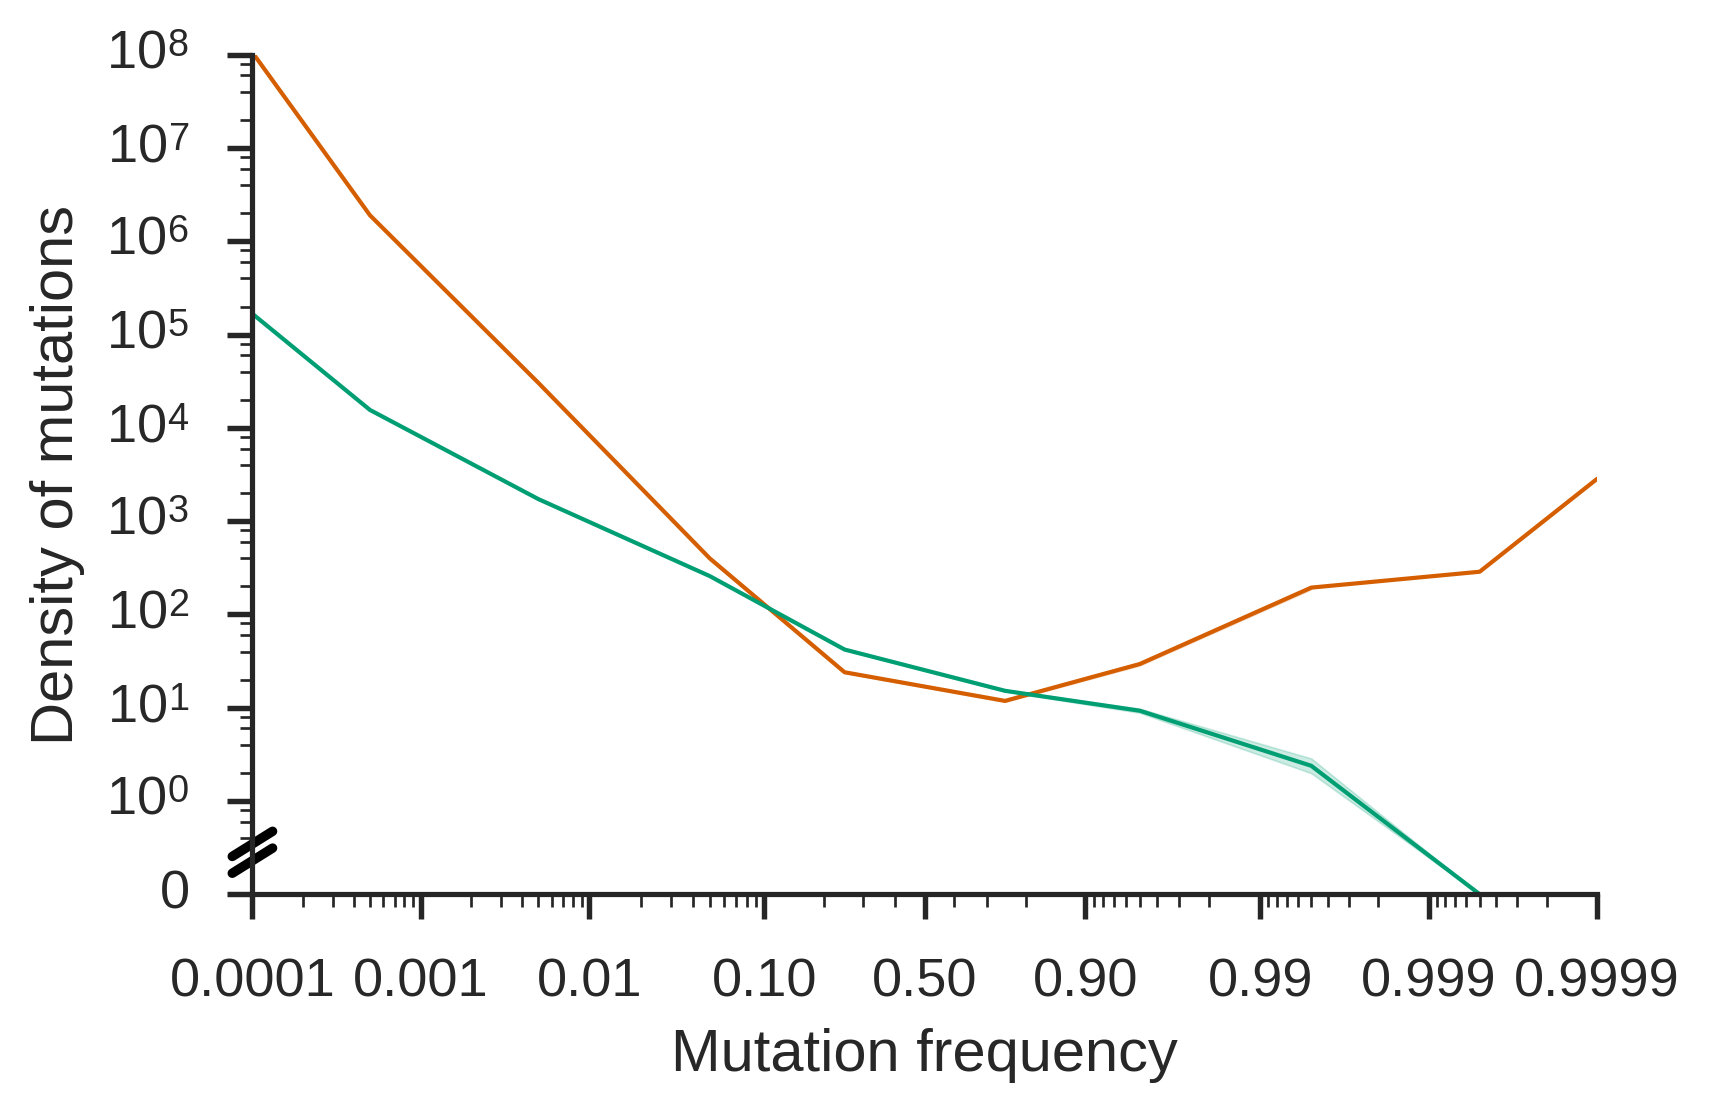

In [423]:
# Models alone for comparison

fig, ax = plt.subplots(1, 1, figsize=(6,4))

y = sim_SFSs_BSC_mean * offset_sim
dy = sim_SFSs_BSC_sem
error = mean_sem_to_error(y, dy)
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[2],
              label="Continuous adaptation", zorder=2)

y = sim_SFSs_kingman_mean * offset_sim
dy = sim_SFSs_kingman_sem
error = mean_sem_to_error(y, dy)
error[0,-2] = 1e-1
error[1,-2] = 1e-1
y[y == 0.0] = 1e-1
plot_sfs_fill(ax, bin_centers_manual, y, error, marker="",
              linewidth=1, color=myColors[3],
              label="Neutral", zorder=2)

ax.set_xlim(1e-5, 1-1e-5)
ax.set_ylim(1e-1, 1e8)

# break in plot
# yticklabels = ax.get_yticklabels()
# yticklabels[1] = "0"

# have to set labels by brute force because it was fucking up
yticklabels = [u'', u'$\\mathdefault{10^{-1}}$', u'$\\mathdefault{10^{0}}$', u'$\\mathdefault{10^{1}}$', u'$\\mathdefault{10^{2}}$', u'$\\mathdefault{10^{3}}$', u'$\\mathdefault{10^{4}}$', u'$\\mathdefault{10^{5}}$', u'$\\mathdefault{10^{6}}$', u'$\\mathdefault{10^{7}}$', u'$\\mathdefault{10^{8}}$', u'']
yticklabels[1]= "0"
ax.set_yticklabels(yticklabels)

d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k',
              clip_on=False) # arguments to pass to plot
ax.plot((-d, +d), (-d+6e-2, +d+6e-2), **kwargs)        # top diagonal
ax.plot((-d, +d), (-d+4e-2, +d+4e-2), **kwargs)        # bottom diagonal

# ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
save_figure(fig, "SFS_Bulk_AllSubjects_expanded_ErrorBars_Break_ModelsOnly", output_dir, output_suffix, output_formats, savefig_args)